# Comparison of h-h and h-$\Lambda$ 2D Correlations
### using THnSparse methods
### Ravi Koka

Use `python-modules` kernel from the global AliPhysics installation. Additionally, ssh into `/broad/` so VSCode activates the .env file. 

In [1]:
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

rt.gStyle.SetOptFit(1111) # show fit panel w/ fit prob, chi2/ndf, fit params, errors

from formatting import process_tf1, process_hist2D, process_hist, process_pave, process_tgraph

# magic for autoreloading modules, useful if import function from another Python file
%load_ext autoreload
%autoreload 2

# cool library, need perm to install
# import hist
# https://hist.readthedocs.io/en/latest/user-guide/notebooks/Plots.html

Welcome to JupyROOT 6.26/10


In [2]:
# NOTES
# SetRangeUser is equivalent to SetRange(FindBin)
# SetRangeUser and FindBin will default to right if number is on bin edge, subtract off small amt to be careful
# hist = thn.Project(0).Clone('name') 
#   gives new string name that ROOT uses (you'll see it in top right corner)
#   need to be careful abt string name, if it gets copied to another object, can go wrong (ex. if set SetRangeUser to original bounds)
# can also use: hist.SetName()
# to reset range use SetRangeUser(0, 0)


# look at how delta eta changes given a pT cut
# check how eta ranges match bin edges
# ADD ASSERT STATEMENTS !!

# dist.GetAxis(axis['trigger eta']).SetRangeUser(-0.8, 0.8)

# if increase pT range, expect 2D corr to get sharper
# can also get more triangular del eta if mess with pT or eta i forgor
#   corr two finite random variables = triangle

# stack vs heap
# https://courses.engr.illinois.edu/cs225/fa2022/resources/stack-heap/#:~:text=stack%20%3A%20stores%20local%20variables,stores%20the%20code%20being%20executed

# binning: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule


#away side / near side (widths) for different cuts and same particle species
#    + div by near side to normalize pT

#do widths ratio for near side
#can try smaller acceptance

#broad can indicate medium intrxn

#if L show diff broadening then hadron, then if we have two diff detector cuts we might not catch it. 

#could mimic broadening (randomly kick particle)

#look into HIJING 

#in PYTHIA, seeing more or less should not effect width of spray

#9/29
#why are tpaves not saving correctly on png
#why is setrangeuser not working for TGraphErrors
#find ryans hard probes talks

#useful: https://cms-opendata-workshop.github.io/workshop2022-lesson-physics-objects/06-substructure/index.html#:~:text=The%20mass%20of%20a%20jet,hadrons%20that%20formed%20the%20jet.

#periodic boundary conditions on delta phi
# important: if i make a hist and then do cuts on original hist, will hist change? will integration change? 

# check that uncerts were calc correctly

# to do
1. Refactor SparseAnalyzer
    - maybe subclass to make fits
    - look into using `__call__`
    - can combine all away- and near-side fits into one method that gets fed an argument to determine the fit function
        - would reduce lines of code
        - also, add way to extract fit params from these
    - add `__str__` method
2. Add more comments to code

## Import the Data

In [3]:
# magic for interactive ROOT plots
%jsroot

In [4]:
# load the ROOT file
inFile = rt.TFile.Open("analysisMultiFine.root")

In [5]:
# load single particle histograms, TH3D
#   axes are: pT, phi, eta
allParticleDist = inFile.allParticleDist
chargedHadronDist = inFile.chargedHadronDist
lambdaDist = inFile.lambdaDist
triggeredLambdaDist = inFile.triggeredLambdaDist

# load correlation dists, 6D THnSparse 
#   axes are: trigger eta, associated eta, trigger pt, associated pt, delta phi, delta eta
hlDist = inFile.hLambdaDist
hhDist = inFile.hhDist

## Classes for Analysis

In [6]:
eps = 0.0001
class SparseAnalyzer:

    def __init__(self, sparse, name, etaAssoc=[-0.8, 0.8-eps], etaTrig=[-0.8, 0.8-eps], ptAssoc=[2, 4-eps], ptTrig=[4, 8-eps], apply_cut=True):
        '''
        Bundles together THnSparse with automatically applied pT and eta cuts, plus useful methods for analysis. Important: apply_cut only toggles the trigger and associate eta cuts. 
        Each method first calls a cutting function, and finishes off with a function that zeros out these cuts. This ensures we can treat our THnSparse like a multidimensional 
        histogram with all cuts already applied, without worrying about changing the underlying THnSparse that ROOT stores a reference to. 

        Attributes
            sparse (THnSparse): THnSparse with 6 axes ordered as: trigger eta, associate eta, trigger pT, associate pT, delta phi, delta eta
            name (string): Name used to generate ROOT names for our THnSparse and histograms. This name should be descriptive. 
                For example, for hadron-hadron data with an eta=[-0.8, 0.8] cut, we might use the name 'hh08'.
            etaAssoc (array-like): Associate single-particle eta cut. Subtract a small epsilon from the right edge to avoid landing exactly on a right bin edge.
            etaTrig (array-like): Trigger single-particle eta cut. Subtract a small epsilon from the right edge to avoid landing exactly on a right bin edge.
            ptAssoc (array-like): Associate single-particle pT cut. Subtract a small epsilon from the right edge to avoid landing exactly on a right bin edge.
            ptTrig (array-like): Trigger single-particle pT cut. Subtract a small epsilon from the right edge to avoid landing exactly on a right bin edge.
            apply_cut (bool): True if we desire a cut on eta, False if not. Note: this does not affect the pT cut.
        '''
        self.sparse = sparse
        self.name = name
        self.apply_cut = apply_cut
        self._axis = {'trigger eta': 0, 'associate eta': 1, 'trigger pT': 2, 'associate pT': 3, 'delta phi': 4, 'delta eta': 5}


        self.ptTrig = ptTrig
        self.ptAssoc = ptAssoc

        if self.apply_cut:
            self.etaTrig = etaTrig
            self.etaAssoc = etaAssoc
            self._cut()

        
    def _cut(self):
        '''
        Applies cut to self.sparse.
        ''' 
        ptTrigMin, ptTrigMax = self.ptTrig
        ptAssocMin, ptAssocMax = self.ptAssoc

        self.sparse.GetAxis(self._axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
        self.sparse.GetAxis(self._axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
        
        if not self.apply_cut:
            return None
        
        etaTrigMin, etaTrigMax = self.etaTrig
        etaAssocMin, etaAssocMax = self.etaAssoc 

        self.sparse.GetAxis(self._axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
        self.sparse.GetAxis(self._axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)

        return None


    def _reset_axes(self):    
        '''
        Resets cut on self.sparse.
        ''' 
        self.sparse.GetAxis(self._axis['trigger pT']).SetRangeUser(0, 0)
        self.sparse.GetAxis(self._axis['associate pT']).SetRangeUser(0, 0)
        self.sparse.GetAxis(self._axis['trigger eta']).SetRangeUser(0, 0)
        self.sparse.GetAxis(self._axis['associate eta']).SetRangeUser(0, 0)


    @staticmethod    
    def _format_dist(dist, color=1, size=1.4, style=20):
        '''
        Format histogram for readability. 
        For configuring color, size, style, see: https://root.cern.ch/doc/master/classTAttMarker.html
        
        Args
            dist (TH1, TH2): Histogram to format.
            color (int): Set marker color.
            size (float): Set marker size
            style (int): Set marker style. 
        '''

        #gPad.SetTickx();
        #gPad.SetTicky();
        dist.SetMarkerSize(size)
        dist.SetMarkerColor(color)
        dist.SetLineColor(color)
        dist.SetMarkerStyle(style)

        dist.GetXaxis().SetTitleFont(42)
        dist.GetXaxis().SetTitleOffset(1.0)
        dist.GetXaxis().SetTitleSize(0.045)
        dist.GetXaxis().SetLabelSize(0.045)

        dist.GetYaxis().SetTitleOffset(1.1)
        dist.GetYaxis().SetTitleSize(0.05)
        dist.GetYaxis().SetLabelSize(0.05)
        dist.GetYaxis().SetLabelFont(42)
        dist.GetXaxis().SetLabelFont(42)
        dist.GetYaxis().SetTitleFont(42)
        

    @staticmethod
    def _process_pave(pave, font=42, size=0.06):
        pave.SetFillStyle(0)
        pave.SetBorderSize(0)
        #pave.SetTextColor(kBlack)
        pave.SetTextSize(size)
        pave.SetTextFont(font)

        return pave


    def make_pave(self):
        pave = rt.TPaveText(0.1, 0.75, 0.5, 0.9, 'NDC')
        pave = self._process_pave(pave)

        pave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
        pave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
    
        if self.apply_cut:
            pave.AddText('|#eta^{trig}| < ' + str(np.abs(self.etaTrig[0])) + ', |#eta^{assoc}| < ' + str(np.abs(self.etaAssoc[0])))
    
        return pave


    def make_1D_hist(self, axis):
        '''
        Make a 1D distribution from a given axis of self.sparse.

        Args
            axis (string): Name of axis to project. Must be 

        Returns
        '''
        self._cut()
        name = {'trigger eta': '_trig_eta', 'associate eta': '_assoc_eta', 'trigger pT': '_trig_pt', 'associate pT': '_assoc_pt', 
                'delta phi': '_dphi', 'delta eta': '_deta'}

        hist = self.sparse.Projection(self._axis[axis])
        hist.GetYaxis().SetRangeUser(0, 1.3 * hist.GetMaximum())
        hist.SetName(f'{self.name}{name[axis]}')
        self._format_dist(hist)
        
        self._reset_axes()

        return hist


    def make_delta_eta(self):
        self._cut()
        dEta = self.sparse.Projection(self._axis['delta eta'])
        dEta.GetYaxis().SetRangeUser(0, 1.3 * dEta.GetMaximum())
        dEta.SetName(f'{self.name}DEta')
        self._format_dist(dEta)

        self._reset_axes()

        return dEta
    
    
    def make_delta_phi(self):
        self._cut()        

        dPhi = self.sparse.Projection(self._axis['delta phi'])
        
        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        self._format_dist(dPhi)
        dPhi.SetName(f'{self.name}DPhi')
        dPhi.GetXaxis().SetTitle('#Delta#varphi (rad)')

        self._reset_axes()

        return dPhi
    
        # raise NotImplementedError, 'implement pave'
    
    
    def make_2D_correlation(self):
        self._cut()        
        dPhiDEta = self.sparse.Projection(self._axis['delta eta'], self._axis['delta phi'])
        dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.2-eps)
        self._format_dist(dPhiDEta)
        dPhiDEta.SetName(f'{self.name}DPhiDEta')

        self._reset_axes()

        return dPhiDEta
    
    
    def integrate_away_side(self):
        '''
        Helper function for get_away_side_ratios(). Calculates the counts in the away side peak of a 2D delta phi delta eta correlation.

        Args
            correlation (TH2):

        Returns
            away_yield (float): 
        '''
        # bounds of integral
        pi = rt.TMath.Pi()
        eps = 0.0001 # in case upper bound lands on right bin edge
        dPhi_lower = pi / 2
        dPhi_upper = 3 * pi / 2 - eps
        dEta_lower = -50
        dEta_upper = 50 - eps

        correlation = self.make_2D_correlation()

        dPhiLowerBin = correlation.GetXaxis().FindBin(dPhi_lower)
        dPhiUpperBin = correlation.GetXaxis().FindBin(dPhi_upper)

        dEtaLowerBin = correlation.GetYaxis().FindBin(dEta_lower)
        dEtaUpperBin = correlation.GetYaxis().FindBin(dEta_upper)

        away_yield = correlation.Integral(dPhiLowerBin, dPhiUpperBin, dEtaLowerBin, dEtaUpperBin)

        return away_yield
    
    
    def integrate_near_side(self):
        '''
        Calculates the counts in the near side peak of a 2D delta phi delta eta correlation.

        Args
            correlation (TH2):

        Returns
            near_yield (float): 
        '''
        # bounds of integral
        pi = rt.TMath.Pi()
        eps = 0.0001 # in case upper bound lands on right bin edge
        dPhi_lower = -pi / 2
        dPhi_upper = pi / 2 - eps
        dEta_lower = -50
        dEta_upper = 50 - eps

        correlation = self.make_2D_correlation()

        dPhiLowerBin = correlation.GetXaxis().FindBin(dPhi_lower)
        dPhiUpperBin = correlation.GetXaxis().FindBin(dPhi_upper)

        dEtaLowerBin = correlation.GetYaxis().FindBin(dEta_lower)
        dEtaUpperBin = correlation.GetYaxis().FindBin(dEta_upper)

        near_yield = correlation.Integral(dPhiLowerBin, dPhiUpperBin, dEtaLowerBin, dEtaUpperBin)

        return near_yield
    
    
    def fit_delta_phi(self, dPhi, fit_params, ratio_plot=False):
        '''
        Args
            dPhi (TH1): delta phi distribution
            fit_params (array_like): Guess parameters. The order of the parameters is: first gaussian amplitude, first gaussian stdev,
                second gaussian amplitude, second gaussian stdev.
            ratio_plot (bool): True if desire a ratio plot, False if only want to fit the TH1. Use this option if you want to analyze residuals. 

        Returns
            None or ratio plot: if ratio_plot is True, returns a ROOT ratio plot. Else, returns None. 
        '''

        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #self._format_dist(dPhi)
        process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_fitted')
        
        doubleGauss = rt.TF1(f'{self.name}_fit', 'gaus(0) + gaus(3)')
        process_tf1(doubleGauss)
        doubleGauss.SetNpx(1000)

        amp_near, stdev_near, amp_away, stdev_away = fit_params
        doubleGauss.SetParameters(amp_near, 0.0, stdev_near, 
                                  amp_away, rt.TMath.Pi(), stdev_away)
        doubleGauss.FixParameter(1, 0.0)
        doubleGauss.FixParameter(4, rt.TMath.Pi())
        # doubleGauss.SetParLimits(2, 0, 100)
        # doubleGauss.SetParLimits(5, 0, 100)
        #doubleGauss.FixParameter(0.18)
        doubleGauss.SetParLimits(5, 0, 100)

        dPhi.Fit(f'{self.name}_fit', 'B')

        
        fit = dPhi.GetFunction(f'{self.name}_fit')
        params = np.array(list(zip([fit.GetParameter(i) for i in range(6)], [fit.GetParError(i) for i in range(6)])), dtype='d')
        
        if ratio_plot:
            # rp.GetLowerRefYaxis().SetTitle("ratio")
            #rp.GetUpperRefYaxis().SetTitle("entries") # kills kernel for unknown reason, maybe because projected from sparse?
            # raise NotImplementedError('need to make sure rp works w/ params')
            return rt.TRatioPlot(dPhi), params
                
        else:
            return dPhi, params
    
    
    def fit_von_mises(self, dPhi, fit_params, ratio_plot=False):
        '''
        Same num of params as gaussian.
        '''
        dPhi.SetName(f'{self.name}_dPhi_fitted_mises')

        # 0: NS Amp/Yield, 1: NS mean, 2: NS kappa, 3: AS Amp/Yield, 4: AS mean, 5: AS kappa
        mises = rt.TF1(f"{self.name}_von_mises", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1])) + [3]/(2*TMath::Pi()*TMath::BesselI0([5]))*TMath::Exp([5]*TMath::Cos(x- 2*TMath::Pi()-[4]))",
                       -rt.TMath.Pi()/2,
                       +(2)*rt.TMath.Pi())
        process_tf1(mises)
        mises.SetNpx(1000)

        amp_near, kappa_near, amp_away, kappa_away = fit_params
        mises.SetParameters(amp_near, 0.0, kappa_near, amp_away, rt.TMath.Pi(), kappa_away)
        # Fix parameter 1 at 0; fix 4 at pi
        mises.FixParameter(1, 0.0)
        mises.FixParameter(4, rt.TMath.Pi())

        dPhi.Fit(f'{self.name}_von_mises', 'B')

        fit = dPhi.GetFunction(f'{self.name}_von_mises')
        params = np.array(list(zip([fit.GetParameter(i) for i in range(6)], [fit.GetParError(i) for i in range(6)])), dtype='d')  
    
        if ratio_plot:
            return rt.TRatioPlot(dPhi), params
                
        else:
            return dPhi, params
    

    def fit_near_von_mises(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fit near-side with Von Mises. 
        '''
        dPhi.SetName(f'{self.name}_dPhi_fitted_near_mises')

        # 0: NS Amp/Yield, 1: NS mean, 2: NS kappa
        mises = rt.TF1(f"{self.name}_von_mises", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1]))",
                       -rt.TMath.Pi()/2,
                       rt.TMath.Pi()/2)
        process_tf1(mises)
        mises.SetNpx(1000)

        amp_near, kappa_near = fit_params
        mises.SetParameters(amp_near, 0.0, kappa_near)
        mises.FixParameter(1, 0.0)

        dPhi.Fit(f'{self.name}_near_von_mises', 'BR')
    
        if ratio_plot:
            return rt.TRatioPlot(dPhi)
                
        else:
            return dPhi 
    
    
    def fit_away_von_mises(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fit away-side with Von Mises. 
        '''
        dPhi.SetName(f'{self.name}_dPhi_fitted_away_mises')

        # 0: AS Amp/Yield, 1: AS mean, 2: AS kappa
        mises = rt.TF1(f"{self.name}_von_mises", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1]))",
                       rt.TMath.Pi()/2,
                       3*rt.TMath.Pi()/2)
        process_tf1(mises)
        mises.SetNpx(1000)

        amp_away, kappa_away = fit_params
        mises.SetParameters(amp_away, 0.0, kappa_away)
        mises.FixParameter(1, rt.TMath.Pi())

        dPhi.Fit(f'{self.name}_away_von_mises', 'B')
    
        if ratio_plot:
            return rt.TRatioPlot(dPhi)
                
        else:
            return dPhi 
        

    def fit_gen_gaussian(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fit generalized Gaussian to delta phi. 
        '''
        
        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #self._format_dist(dPhi)
        #process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_fitted_gen')
        
        # 0: Mean NS, 1: alpha NS, 2: beta NS, 3: Amp GGaus NS, 4: Mean AS, 5: alpha AS, 6: beta AS, 7: Amp GGaus AS 
        genGauss = rt.TF1(f'{self.name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2])) + [7]*([6]/(2*[5]*TMath::Gamma(1/[6])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[4])/[5],[6]))",
                          -rt.TMath.Pi()/2,
                          +3*rt.TMath.Pi()/2)
        process_tf1(genGauss)
        genGauss.SetNpx(1000)

        mean_near, alpha_near, beta_near, amp_near, mean_away, alpha_away, beta_away, amp_away = fit_params
        genGauss.SetParameters(mean_near, alpha_near, beta_near, amp_near, mean_away, alpha_away, beta_away, amp_away) 

        genGauss.FixParameter(0, 0.0)
        genGauss.FixParameter(4, rt.TMath.Pi())

        genGauss.SetParLimits(2, 1, 2)
        genGauss.SetParLimits(6, 1, 2)

        dPhi.Fit(f'{self.name}_fit', 'B')
        
        fit = dPhi.GetFunction(f'{self.name}_fit')
        params = np.array(list(zip([fit.GetParameter(i) for i in range(8)], [fit.GetParError(i) for i in range(8)])), dtype='d')  

        if ratio_plot:
            return rt.TRatioPlot(dPhi), params
                
        else:
            return dPhi, params
    
    
    @staticmethod
    def calc_gen_gaussian_widths(params):
        '''
        Calculate NS and AS standard deviations given fitted params from fit_gen_gaussian().
        '''
        alpha_near, alpha_near_uncert = params[1]
        beta_near, beta_near_uncert = params[2]

        alpha_away, alpha_away_uncert = params[5] 
        beta_away, beta_away_uncert = params[6]

        
        var_near = (alpha_near ** 2) * rt.TMath.Gamma(3 / beta_near) / rt.TMath.Gamma(1 / beta_near)
        var_away = (alpha_away ** 2) * rt.TMath.Gamma(3 / beta_away) / rt.TMath.Gamma(1 / beta_away)

        stdev_near = np.sqrt(var_near)
        stdev_away = np.sqrt(var_away)

        raise NotImplementedError('Implement uncertainties')
        return stdev_near, stdev_away


    def fit_near_gen_gaussian(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fit generalized Gaussian to delta phi near-side. 
        '''
        
        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #self._format_dist(dPhi)
        #process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_near_fitted_gen')
        
        # 0: Mean NS, 1: alpha NS, 2: beta NS, 3: Amp GGaus NS
        genGauss = rt.TF1(f'{self.name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2]))",
                          -rt.TMath.Pi()/2,
                          rt.TMath.Pi()/2)
        process_tf1(genGauss)
        genGauss.SetNpx(1000)

        mean_near, alpha_near, beta_near, amp_near = fit_params
        genGauss.SetParameters(mean_near, alpha_near, beta_near, amp_near)
        genGauss.FixParameter(0, 0.0)
        genGauss.SetParLimits(2, 1, 2)

        dPhi.Fit(f'{self.name}_near_gen_gauss_fit', 'BR')

        if ratio_plot:
            return rt.TRatioPlot(dPhi)
                
        else:
            return dPhi
        
    
    def fit_away_gen_gaussian(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fit generalized Gaussian to delta phi away-side. 
        '''
        
        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #self._format_dist(dPhi)
        #process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_away_fitted_gen')
        
        # 0: Mean AS, 1: alpha AS, 2: beta AS, 3: Amp GGaus AS 
        genGauss = rt.TF1(f'{self.name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2]))",
                          rt.TMath.Pi()/2,
                          3*rt.TMath.Pi()/2)
        process_tf1(genGauss)
        genGauss.SetNpx(1000)

        mean_away, alpha_away, beta_away, amp_away = fit_params
        genGauss.SetParameters(mean_away, alpha_away, beta_away, amp_away)
        genGauss.FixParameter(0, rt.TMath.Pi())
        genGauss.SetParLimits(2, 1, 2)

        dPhi.Fit(f'{self.name}_away_gen_gauss_fit', 'BR')

        if ratio_plot:
            return rt.TRatioPlot(dPhi)
                
        else:
            return dPhi
        
    def fit_near_side(self, dPhi, fit_params, ratio_plot=False):
        '''
        Fits the near-side peak of a delta phi distribution. The near side is defined as all points between a delta phi of -pi/2 and

        Args

        Returns

        '''

        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_near_fitted')

        pi = rt.TMath.Pi()
        near_gaus = rt.TF1(f'{self.name}_near_fit', 'gaus', -pi/2, pi/2)
        process_tf1(near_gaus)
        near_gaus.SetNpx(1000)

        amp_near, stdev_near = fit_params
        near_gaus.SetParameters(amp_near, 0.0, stdev_near)
        near_gaus.FixParameter(1, 0.0)
        # near_gaus.SetParLimits(2, 0, 100)
        #near_gaus.FixParameter(2, 0.181)

        dPhi.Fit(f'{self.name}_near_fit', 'BR')

        
        fit = dPhi.GetFunction(f'{self.name}_near_fit')
        params = np.array(list(zip([fit.GetParameter(i) for i in range(3)], [fit.GetParError(i) for i in range(3)])), dtype='d')

        if ratio_plot:
            return rt.TRatioPlot(dPhi), params
                
        else:
            return dPhi, params
 

    def fit_away_side(self, dPhi, fit_params, ratio_plot=False):
        '''
        Args

        Returns
        '''
        dPhi.GetYaxis().SetRangeUser(0, 1.3 * dPhi.GetMaximum())
        #process_hist(dPhi)
        dPhi.SetName(f'{self.name}_dPhi_away_fitted')

        pi = rt.TMath.Pi()
        away_gaus = rt.TF1(f'{self.name}_away_fit', 'gaus', pi/2, 3*pi/2)
        process_tf1(away_gaus)
        away_gaus.SetNpx(1000)

        amp_away, stdev_away = fit_params
        away_gaus.SetParameters(amp_away, pi, stdev_away)
        away_gaus.FixParameter(4, pi)
        away_gaus.SetParLimits(5, 0, 100)

        dPhi.Fit(f'{self.name}_away_fit', 'BR')

        fit = dPhi.GetFunction(f'{self.name}_away_fit')
        params = np.array(list(zip([fit.GetParameter(i) for i in range(3)], [fit.GetParError(i) for i in range(3)])), dtype='d')
        #raise NotImplementedError
    
        if ratio_plot:
            return rt.TRatioPlot(dPhi), params
        else:
            return dPhi, params

In [7]:
class FitFunction(Enum):
    gaussian = 'gaussian'
    generalized_gassian = 'generalized_gaussian' 
    von_mises = 'von_mises'
    double_gaussian = 'double_gaussian'
    double_generalized_gaussian = 'double_gen_gaussian'
    double_von_mises = 'double_von_mises'

class FitRange(Enum):
    away_side = 'away_side'
    near_side = 'near_side'
    full_range = 'full_range'

In [8]:
class CurveFit:
    def __init__(self, sparse, dphi, fit_function, fit_range, fit_params, ratio_plot=False):
        '''
        Defines an easy-to-use API for fitting delta phi distributions for various fit functions and ranges. The internals are ugly, but it is easily maintainable.

        Attributes:
            sparse (SparseAnalyzer): takes name from SparseAnalyzer, might make this generate the dphi distribution automatically
            dphi (TH1): delta phi distribution to fit
            fit_function (Enum): option from FitFunction. Defines the fit function that gets used.
            fit_range (Enum): option from FitRange. Defines the range we want to fit over (near, away, entire domain).
            fit_params (array-like): guess parameters for fit. Guess for means are used to fix the mean in fits. 
            ratio_plot (boolean): True if want a ratio plot from the fit method. False if not. 
        
        To do:
        Think abt if should build dphi in constructor.
        '''
        self.name = sparse.name
        self.dphi = dphi
        self.f = None
        #self.fit_params = fit_params
        self.fit_range = fit_range
        self.ratio_plot = ratio_plot
        self.fit_name = f'{self.name}_{fit_function.value}_{fit_range.value}'

        self.dphi.SetName(f'{self.fit_name}_dphi')
        self.dphi.GetYaxis().SetRangeUser(0, 1.3 * self.dphi.GetMaximum())

        pi = rt.TMath.Pi()

        # set what range we fit over
        if fit_range is FitRange.full_range:
            self.fit_range = [-pi/2, 3*pi/2]

        elif fit_range is FitRange.near_side:
            self.fit_range = [-pi/2, pi/2]

        elif fit_range is FitRange.away_side:
            self.fit_range = [pi/2, 3*pi/2]
        
        # define fit function, fix params and set param ranges
        if fit_function is FitFunction.gaussian:

            self.f = rt.TF1(f'{self.fit_name}_fit', 'gaus', *self.fit_range)
            self._num_params = 3

            amp, mean, stdev = fit_params
            self.f.SetParameters(amp, mean, stdev)
            self.f.FixParameter(1, mean) # fix mean
            self.f.SetParLimits(2, 0.0, 100) # ensure stdev is positive to reduce param space

        elif fit_function is FitFunction.generalized_gassian:

            # 0: mean, 1: alpha, 2: beta, 3: amp
            self.f = rt.TF1(f'{self.fit_name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2]))",
                            *self.fit_range) 
            self._num_params = 4           

            mean, alpha, beta, amp = fit_params
            self.f.SetParameters(mean, alpha, beta, amp)
            self.f.FixParameter(0, mean) # fix mean 
            self.f.SetParLimits(2, 1, 2) # limit beta
        
        elif fit_function is FitFunction.von_mises:
            
            # 0: Amp/Yield, 1: mean, 2: kappa
            self.f = rt.TF1(f"{self.fit_name}_fit", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1]))",
                        *self.fit_range)
            self._num_params = 3
            
            amp, mean, kappa = fit_params
            self.f.SetParameters(amp, mean, kappa)
            self.f.FixParameter(1, mean) # fix mean

        elif fit_function is FitFunction.double_gaussian:
            
            self.f = rt.TF1(f'{self.fit_name}_fit', 'gaus(0) + gaus(3)', *self.fit_range)
            self._num_params = 6

            amp_near, mean_near, stdev_near, amp_away, mean_away, stdev_away = fit_params
            self.f.SetParameters(amp_near, mean_near, stdev_near, 
                                    amp_away, mean_away, stdev_away)
            self.f.FixParameter(1, mean_near)
            self.f.FixParameter(4, mean_away)
            self.f.SetParLimits(2, 0, 100)
            self.f.SetParLimits(5, 0, 100)

        elif fit_function is FitFunction.double_generalized_gaussian:
            
            # 0: Mean NS, 1: alpha NS, 2: beta NS, 3: Amp GGaus NS, 4: Mean AS, 5: alpha AS, 6: beta AS, 7: Amp GGaus AS 
            self.f = rt.TF1(f'{self.fit_name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2])) + [7]*([6]/(2*[5]*TMath::Gamma(1/[6])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[4])/[5],[6]))",
                        *self.fit_range)
            self._num_params = 8

            mean_near, alpha_near, beta_near, amp_near, mean_away, alpha_away, beta_away, amp_away = fit_params
            self.f.SetParameters(mean_near, alpha_near, beta_near, amp_near, mean_away, alpha_away, beta_away, amp_away) 

            self.f.FixParameter(0, mean_near)
            self.f.FixParameter(4, mean_away)

            self.f.SetParLimits(2, 1, 2)
            self.f.SetParLimits(6, 1, 2)

        elif fit_function is FitFunction.double_von_mises:
            
            # 0: NS Amp/Yield, 1: NS mean, 2: NS kappa, 3: AS Amp/Yield, 4: AS mean, 5: AS kappa
            self.f = rt.TF1(f"{self.fit_name}", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1])) + [3]/(2*TMath::Pi()*TMath::BesselI0([5]))*TMath::Exp([5]*TMath::Cos(x- 2*TMath::Pi()-[4]))",
                        *self.fit_range)
            self._num_params = 6

            amp_near, mean_near, kappa_near, amp_away, mean_away, kappa_away = fit_params
            self.f.SetParameters(amp_near, mean_near, kappa_near, amp_away, mean_away, kappa_away)
            # Fix parameter 1 at 0; fix 4 at pi
            self.f.FixParameter(1, mean_near)
            self.f.FixParameter(4, mean_away)            
        
        process_tf1(self.f)
        self.f.SetNpx(1000)

        
    def fit(self):
        '''
        Apply fit to delta phi distribution.

        Returns
            Fitted TH1 or TRatioPlot: TRatioPlot if ratio_plot is true, TH1 if not.
            params_w_err (numpy array): Parameters and errors, shape=(number of parameters, 2)
        '''
        self.dphi.Fit(f'{self.fit_name}_fit', 'BR')

        params = [self.f.GetParameter(i) for i in range(self._num_params)]
        errs = [self.f.GetParError(i) for i in range(self._num_params)]
        params_w_err = np.array(list(zip(params, errs)), dtype='d')

        if self.ratio_plot:
            return rt.TRatioPlot(self.dphi), params_w_err
        else:
            return self.dphi, params_w_err

In [9]:
def format_hist(hist, color=1, size=1.4, style=20):
    '''
    Format histogram for readability. 
    
    Args
        hist (TH1, TH2): histogram
    '''

    #gPad.SetTickx();
    #gPad.SetTicky();
    hist.SetMarkerSize(size)
    hist.SetMarkerColor(color)
    hist.SetLineColor(color)
    hist.SetMarkerStyle(style)

    hist.GetXaxis().SetTitleFont(42)
    hist.GetXaxis().SetTitleOffset(1.0)
    hist.GetXaxis().SetTitleSize(0.045)
    hist.GetXaxis().SetLabelSize(0.045)

    hist.GetYaxis().SetTitleOffset(1.1)
    hist.GetYaxis().SetTitleSize(0.05)
    hist.GetYaxis().SetLabelSize(0.05)
    hist.GetYaxis().SetLabelFont(42)
    hist.GetXaxis().SetLabelFont(42)
    hist.GetYaxis().SetTitleFont(42)
    

def make_projection_plots(sparse):
    '''
    Makes 1D histograms of quantities from THnSparse, and 2D delta phi delta eta correlation. 
    No single particle cuts applied in this function. 

    Args
        sparse (SparseAnalyzer):
    
    Returns
        canvas (TCanvas): 
    '''

    # project to make 1D hists
    trigEta = sparse.make_1D_hist('trigger eta')
    assocEta = sparse.make_1D_hist('associate eta')
    trigPt = sparse.make_1D_hist('trigger pT')
    assocPt = sparse.make_1D_hist('associate pT')
    dEta = sparse.make_1D_hist('delta eta') 

    # project into 2D correlations and delta eta dist
    dPhiDEta = sparse.make_2D_correlation()
    #dEta = dPhiDEta.ProjectionY()

    # make canvas
    rt.gStyle.SetOptStat(11)
    canvas = rt.TCanvas(f'{sparse.name}_plots_canvas', f'{sparse.name}_plots')
    canvas.SetCanvasSize(1800, 800)
    canvas.Divide(3, 2)

    canvas.cd(1)
    format_hist(trigEta)
    trigEta.GetYaxis().SetRangeUser(0, 1.3*trigEta.GetMaximum())
    trigEta.SetTitle('Trigger #eta')
    trigEta.SetXTitle('#eta')
    trigEta.SetYTitle('counts')
    trigEta.Draw('COLZ')


    canvas.cd(2)
    format_hist(assocEta)
    assocEta.SetTitle('Associate #eta')
    assocEta.SetXTitle('#eta')
    assocEta.SetYTitle('counts')
    assocEta.Draw('COLZ')


    canvas.cd(3)
    format_hist(trigPt)
    trigPt.SetTitle('Trigger p_{T}')
    trigPt.SetXTitle('p_{T}')
    trigPt.SetYTitle('counts')
    trigPt.Draw('COLZ')


    canvas.cd(4)
    format_hist(assocPt)
    assocPt.SetTitle('Associate p_{T}')
    assocPt.SetXTitle('p_{T}')
    assocPt.SetYTitle('counts')
    assocPt.Draw('COLZ')


    canvas.cd(5)
    format_hist(dPhiDEta)
    dPhiDEta.SetTitle('Correlation')
    dPhiDEta.SetXTitle('#Delta#varphi')
    dPhiDEta.SetYTitle('#Delta#eta')
    dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.199)
    dPhiDEta.Draw('SURF1')


    canvas.cd(6)
    format_hist(dEta)
    dEta.SetTitle('#Delta#eta')
    dEta.SetXTitle('#Delta#eta')
    dEta.SetYTitle('counts')
    dEta.Draw()    

    return canvas

In [9]:
hh = SparseAnalyzer(hhDist, name='hh', apply_cut=False)
hh08 = SparseAnalyzer(hhDist, name='hh08', etaAssoc=[-0.8, 0.8-eps], apply_cut=True)
hh12 = SparseAnalyzer(hhDist, name='hh12', etaAssoc=[-1.2, 1.2-eps], apply_cut=True)
hh20 = SparseAnalyzer(hhDist, name='hh20', etaAssoc=[-2.0, 2.0-eps], apply_cut=True)

hl = SparseAnalyzer(hlDist, name='hl', apply_cut=False)
hl08 = SparseAnalyzer(hlDist, name='hl08', etaAssoc=[-0.8, 0.8-eps], apply_cut=True)
hl12 = SparseAnalyzer(hlDist, name='hl12', etaAssoc=[-1.2, 1.2-eps], apply_cut=True)
hl20 = SparseAnalyzer(hlDist, name='hl20', etaAssoc=[-2.0, 2.0-eps], apply_cut=True)

In [10]:
t = hh12.make_delta_phi()
t.Integral()

71558.0

In [14]:
a = hh08.make_delta_phi() 

ac = rt.TCanvas()

ac.Draw()
a.Draw()

In [20]:
b = rt.TCanvas()
a.Scale(1 / a.Integral())

a.Draw()
b.Draw()

In [11]:
c = rt.TCanvas()
dphi = hh08.make_delta_phi() / dphi.Integral()
gen_gaussian = CurveFit(sparse=hh08, dphi=dphi, fit_function=FitFunction.double_generalized_gaussian, 
                        fit_range=FitRange.full_range, fit_params=[0.0, 2.28160e-01, 1.65955e+00, 7.16008e+03, rt.TMath.Pi(), 1, 1.8, 5e3], ratio_plot=True)
dphi, _ = gen_gaussian.fit()

dphi.Draw()
c.Draw()

NameError: name 'dphi' is not defined

In [14]:
pc = rt.TCanvas()
dphi = hh08.make_delta_phi()
dphi.SetMarkerStyle(1)

dphi, _ = hh08.fit_gen_gaussian(dphi, fit_params=[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], ratio_plot=True)

pc.Draw()
dphi.Draw()

 FCN=348.898 FROM MIGRAD    STATUS=CONVERGED     580 CALLS         581 TOTAL
                     EDM=1.99523e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           0.00000e+00     fixed    
   2  p1           2.28160e-01   2.37907e-03  -7.28551e-07   9.41869e-03
   3  p2           1.65955e+00   1.90371e-02  -1.24879e-05  -2.00012e-04
   4  p3           7.16008e+03   3.82681e+01  -2.66593e-02   6.73976e-07
   5  p4           3.14159e+00     fixed    
   6  p5           4.45724e-01   5.94310e-03  -9.22546e-07  -9.88314e-03
   7  p6           1.51161e+00   2.38460e-02  -1.83115e-05   7.69598e-04
   8  p7           4.24292e+03   2.88990e+01  -2.04879e-02   2.66741e-06


In [17]:
pca = rt.TCanvas()

dphi = hh08.make_delta_phi()

genGauss = rt.TF1(f'{hh08.name}_fit', "[3]*([2]/(2*[1]*TMath::Gamma(1/[2])))*TMath::Exp(-TMath::Power(TMath::Abs(x-[0])/[1],[2]))",
                    rt.TMath.Pi()/2,
                    +3*rt.TMath.Pi()/2)
#process_tf1(genGauss)
genGauss.SetNpx(1000)

mean_away, alpha_away, beta_away, amp_away = [1, 1, 1.8, 1]
genGauss.SetParameters(mean_away, alpha_away, beta_away, amp_away) 

genGauss.FixParameter(0, rt.TMath.Pi())
genGauss.SetParLimits(2, 1, 2)

dphi.Fit(f'{hh08.name}_fit', 'BR')

rp = rt.TRatioPlot(dphi)
rp.Draw()
pca.Draw()

 FCN=19.5582 FROM MIGRAD    STATUS=CONVERGED     151 CALLS         152 TOTAL
                     EDM=1.22782e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.14159e+00     fixed    
   2  p1           4.46481e-01   5.97795e-03   5.59017e-06  -1.20089e-01
   3  p2           1.51599e+00   2.42760e-02   4.54294e-05   1.11650e-02
   4  p3           4.24239e+03   2.89340e+01   6.39855e-02  -1.32135e-05


In [21]:
tc = rt.TCanvas()

dphi = hh08.make_delta_phi()
dphi.SetName('myname')
dphi, _ = hh08.fit_von_mises(dphi, [1, 1, 1, 1], ratio_plot=True)

dphi.Draw()
tc.Draw()

 FCN=738.561 FROM MIGRAD    STATUS=CONVERGED     209 CALLS         210 TOTAL
                     EDM=7.74714e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.05002e+03   3.74697e+01  -2.40064e-02  -1.32182e-06
   2  p1           0.00000e+00     fixed    
   3  p2           3.08074e+01   2.79137e-01   5.43688e-04   6.79882e-05
   4  p3           4.19716e+03   2.95836e+01   3.44216e-03  -2.31049e-07
   5  p4           3.14159e+00     fixed    
   6  p5           7.68186e+00   8.53137e-02  -1.56271e-06  -4.15551e-05


In [20]:
canv = rt.TCanvas()
dphi = hh08.make_delta_phi()
dphi.SetName('new name')

dphi, _ = hh08.fit_delta_phi(dphi, [1e4, 1, 1e3, 1], ratio_plot=True)

dphi.Draw()
canv.Draw()

 FCN=864.367 FROM MIGRAD    STATUS=CONVERGED     213 CALLS         214 TOTAL
                     EDM=5.35139e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.54928e+04   1.09520e+02   1.67813e-01  -8.08311e-07
   2  p1           0.00000e+00     fixed    
   3  p2           1.81362e-01   8.51747e-04  -6.92637e-07  -1.64572e-04
   4  p3           4.50821e+03   4.11940e+01   7.40834e-02  -3.64879e-06
   5  p4           3.14159e+00     fixed    
   6  p5           3.69843e-01   2.23609e-03  -1.19796e-07  -2.68099e-01


In [30]:
pca1 = rt.TCanvas()
dphi = hh08.make_delta_phi()

dphi, _ = hh08.fit_away_side(dphi, fit_params=[6e3, 1], ratio_plot=True)


dphi.Draw()
pca1.Draw()

 FCN=279.882 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=2.10981e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.50820e+03   4.11909e+01   2.52827e-01  -5.12311e-06
   2  Mean         3.13879e+00   2.53634e-03   2.07474e-05  -2.48051e-01
   3  Sigma        3.69863e-01   2.23511e-03   1.37165e-05  -8.60130e-02


In [31]:
pc1 = rt.TCanvas()
dphi = hl08.make_delta_phi()
dphi.SetMarkerStyle(1)

pc1.Draw()
dphi.Draw()

In [32]:
c = rt.TCanvas()

dphi = hh08.make_delta_phi()
print(dphi.Integral()) # 58020
dphi.Scale(1.0 / dphi.Integral())
dphi.Rebin(2)

dphi.SetName(f'{hh08.name}_dPhi_fitted_mises')

# 0: NS Amp/Yield, 1: NS mean, 2: NS kappa, 3: AS Amp/Yield, 4: AS mean, 5: AS kappa
#mises = rt.TF1(f"{hh08.name}_von_mises", "[0]/(2*TMath::Pi()*TMath::BesselI0([2]))*TMath::Exp([2]*TMath::Cos(x- 2*TMath::Pi() - [1]))",
 #               -rt.TMath.Pi()/2, rt.TMath.Pi()/2)
#mises = rt.TF1(f"{hh08.name}_von_mises", "1/(2*TMath::Pi()*TMath::BesselI0([1]))*TMath::Exp([1]*TMath::Cos(x- 2*TMath::Pi() - [0]))",
 #               -rt.TMath.Pi()/2, rt.TMath.Pi()/2)
                #+(2)*rt.TMath.Pi())
#process_tf1(mises)
#mises.SetNpx(1000)

#amp_near, kappa_near = 100, 100
#, amp_away, kappa_away = 
#mises.SetParameters(amp_near, 0.0, kappa_near)#, amp_away, rt.TMath.Pi(), kappa_away)
# Fix parameter 1 at 0; fix 4 at pi
#mises.FixParameter(1, 0.0)
#mises.FixParameter(0, 0.0)
#mises.SetParLimits(2, 0, 0.13)
#mises.FixParameter(4, rt.TMath.Pi())

#dphi.Fit(f'{hh08.name}_von_mises', 'BR')
rp, params = hh08.fit_near_side(dPhi=dphi, fit_params=[0.3, 0.1], ratio_plot=True)
#fit = dPhi.GetFunction(f'{self.name}_von_mises')
#params = np.array(list(zip([fit.GetParameter(i) for i in range(6)], [fit.GetParError(i) for i in range(6)])), dtype='d') 


# ns_yield = hh08.integrate_near_side()
# print(ns_yield)

#dphi, params = hh08.fit_gen_gaussian(dphi, fit_params=[0.0, 0.2, 0.1, 1, 1, 1, 1.4, 1])
#dphi, params = hh08.fit_von_mises(dphi, fit_params=[1, 0.9, 10000, 0.9])


#dphi, params = hl08.fit_von_mises(dphi, fit_params=[10000, 0.9, 10000, 0.9])
#dphi, params = hl08.fit_gen_gaussian(dphi, fit_params=[0.0, 0.2, 0.1, 1, 1, 1, 1.4, 1])

#rp = rt.TRatioPlot(dphi, 'diff')
#rp.Draw()

c.Draw()
rp.Draw()
#dphi.Draw()

58020.0
 FCN=26.8087 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=3.76725e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.41183e-01   2.99938e-03   5.95240e-06   2.62815e-03
   2  Mean         0.00000e+00     fixed    
   3  Sigma        2.23685e-01   9.29488e-04   1.84475e-06   1.20743e-02


 FCN=29.7219 FROM MIGRAD    STATUS=CONVERGED      54 CALLS          55 TOTAL
                     EDM=1.53143e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.95847e+02   6.87936e+00   1.51943e-02  -5.07531e-05
   2  Mean         6.95631e-03   1.42942e-02   3.86803e-05  -9.96876e-03
   3  Sigma        1.00274e+00   1.01683e-02   7.41023e-06  -1.95139e-01
Formula based function:     name 
                 name : gaus(0) Ndim= 1, Npar= 3, Number= 100 
 Formula expression: 
	[Constant]*exp(-0.5*((x-[Mean])/[Sigma])*((x-[Mean])/[Sigma])) 


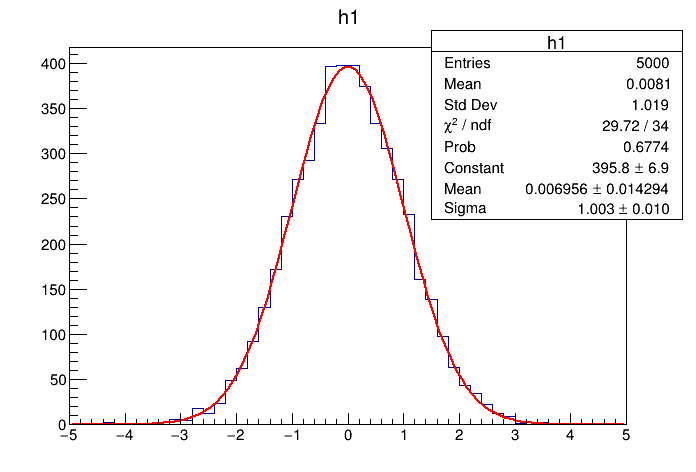

In [2]:
c1 = rt.TCanvas()
h1 = rt.TH1D('h1', 'h1', 50,-5,5)
h1.FillRandom('gaus')
#h1.Fit('gaus', '0')
f = rt.TF1('name', 'gaus(0)')

#params 

#rp = rt.TRatioPlot(h1, 'diff')
h1.Fit('name')

#params = f.GetParameters()
#errs = f.GetParErrors()

#l = [p for p in params]
#print(params, errs)

f.Print()
h1.Draw()
c1.Draw()

In [14]:
c = rt.TCanvas()
phi = hh08.make_delta_phi()

pave = rt.TPaveText(0.1, 0.75, 0.5, 0.9, 'NDC')
#pave = self._process_pave(pave)

pave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
pave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')

pave.AddText('|#eta^{trig}| < ' + str(np.abs(hh08.etaTrig[0])) + ', |#eta^{assoc}| < ' + str(np.abs(hh08.etaAssoc[0])))
process_pave(pave)

phi.Draw()
c.Draw()
pave.Draw()

In [22]:
c1 = rt.TCanvas()
hh100 = SparseAnalyzer(hhDist, name='hh100', etaAssoc=[-500.0, 500.0-eps], apply_cut=True)
phi100 = hh100.make_delta_phi()

pave = rt.TPaveText(0.1, 0.75, 0.5, 0.9, 'NDC')
#pave = self._process_pave(pave)

pave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
pave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')

pave.AddText('|#eta^{trig}| < ' + str(np.abs(hh100.etaTrig[0])) + ', |#eta^{assoc}| < ' + str(np.abs(hh100.etaAssoc[0])))
process_pave(pave)

phi100.Draw()
c1.Draw()
pave.Draw()

In [12]:
def process_TPave(pave, font=42, size=0.06):
    pave.SetFillStyle(0)
    pave.SetBorderSize(0)
    #pave.SetTextColor(kBlack)
    pave.SetTextSize(size)
    pave.SetTextFont(font)
    
    return pave

In [13]:
c = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

dphi = hh12.make_delta_phi()
pave = hh12.make_pave()
dphi, params = hh12.fit_delta_phi(dphi, [18000, 1, 15000, 1], False)
pave.AddText('#sigma_{NS} = ' + str(np.round(params[2][0], 4)) + ' #pm ' + str(np.round(params[2][1], 4)))
pave.AddText('#sigma_{AS} = ' + str(np.round(params[5][0], 4)) + ' #pm ' + str(np.round(params[5][1], 4)))

print(params)

#pave = rt.TPaveText(0.1, 0.75, 0.5, 0.9, 'NDC')
#pave = process_TPave(pave)
# pave = process_TPave(pave)
#pave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
#pave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
#pave.AddText('-0.8 < #eta^{trig} < 0.8, -0.8 < #eta^{assoc} < 0.8')
#pave.AddText('p_{T}^{trig} #in [4, 8] GeV/c')
#pave.AddText('p_{T}^{assoc} #in [2, 4] GeV/c')
#pave.AddText('#eta^{trig} #in [-0.8, 0.8]')
#pave.AddText('#eta^{assoc} #in [-0.8, 0.8]')


# dphi, params = hh.fit_delta_phi(dphi, [18000, 1, 4000, 1], ratio_plot=False)

dphi.Draw()
pave.Draw()

c.Draw()

[[1.67393067e+04 1.13718894e+02]
 [0.00000000e+00 0.00000000e+00]
 [1.82752787e-01 8.28407674e-04]
 [6.70140322e+03 4.89381794e+01]
 [3.14159265e+00 0.00000000e+00]
 [3.68106255e-01 1.81758297e-03]]
 FCN=1012.64 FROM MIGRAD    STATUS=CONVERGED     271 CALLS         272 TOTAL
                     EDM=4.36053e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.67393e+04   1.13719e+02  -5.81001e-02  -1.50861e-07
   2  p1           0.00000e+00     fixed    
   3  p2           1.82753e-01   8.28408e-04   6.63069e-07  -3.82692e-01
   4  p3           6.70140e+03   4.89382e+01  -4.62076e-02  -5.76495e-08
   5  p4           3.14159e+00     fixed    
   6  p5           3.68106e-01   1.81758e-03   6.46732e-07  -1.29083e+00


In [17]:
distributions = [hh, hh08, hh12, hh20, hl, hl08, hl12, hl20]

In [14]:
canvases = []
for dist in distributions:
    canvases.append(make_projection_plots(dist))

In [15]:
c1, c2, c3, c4, c5, c6, c7, c8 = canvases

In [16]:
c4.Draw()

In [17]:
c2.Draw()

## $\Delta\varphi$ Widths

In [18]:
# standard gaussian fit

dir = '/home/ravikkoka/alice/broad/plots/'

dPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')

dPhiCanvas.SetCanvasSize(2400, 800)
dPhiCanvas.Divide(4, 2)

guesses = [[18000, 1, 4000, 1], [20000, 1, 8000, 1], [20000, 1, 15000, 1], [20000, 1, 20000, 1],
           [200, 1, 800, 1], [100, 1, 150, 1], [100, 0.19, 250, 1], [100, 1, 400, 1]]
awayStDev = np.zeros(shape=(len(distributions), 2))
nearStDev = np.zeros(shape=(len(distributions), 2))
for i, (sparse, guess) in enumerate(zip(distributions, guesses)):
    dPhiCanvas.cd(i + 1)

    dPhi = sparse.make_delta_phi()
    dPhi, params = sparse.fit_delta_phi(dPhi, guess, ratio_plot=False)
    
    nearStDev[i] = params[2]
    awayStDev[i] = params[5]

    pave = sparse.make_pave()    
    dPhi.Draw()
    pave.Draw()
        
dPhiCanvas.SaveAs(dir + 'delta_phi_plots.png')
dPhiCanvas.Draw()

 FCN=3109.89 FROM MIGRAD    STATUS=CONVERGED     216 CALLS         217 TOTAL
                     EDM=7.92178e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.82460e+04   1.71190e+02  -9.55145e-02   1.11936e-06
   2  p1           0.00000e+00     fixed    
   3  p2           1.84284e-01   5.50658e-04  -1.40221e-07   1.65863e+00
   4  p3           2.33132e+04   9.50246e+01   8.25036e-03  -6.76019e-07
   5  p4           3.14159e+00     fixed    
   6  p5           3.60653e-01   9.94202e-04  -8.73726e-08  -6.87643e-02
 FCN=864.367 FROM MIGRAD    STATUS=CONVERGED     266 CALLS         267 TOTAL
                     EDM=4.57393e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DE

Info in <TCanvas::Print>: png file /home/ravikkoka/alice/broad/plots/delta_phi_plots.png has been created


In [19]:
# general gaussian fit
""" 
dir = '/home/ravikkoka/alice/broad/plots/'

dPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')

dPhiCanvas.SetCanvasSize(2400, 800)
dPhiCanvas.Divide(4, 2)

guesses = [[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1],
           [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1]]

awayStDev = np.zeros(shape=(len(distributions), 2))
nearStDev = np.zeros(shape=(len(distributions), 2))
for i, (sparse, guess) in enumerate(zip(distributions, guesses)):
    dPhiCanvas.cd(i + 1)

    dPhi = sparse.make_delta_phi()
    dPhi, params = sparse.fit_gen_gaussian(dPhi, guess)
    
    nearStDev[i], awayStDev[i] = sparse.calc_gen_gaussian_widths(params) 

    dPhi.Draw()
    pave.Draw()
        
dPhiCanvas.SaveAs(dir + 'delta_phi_plots_general.png')
dPhiCanvas.Draw() """

" \ndir = '/home/ravikkoka/alice/broad/plots/'\n\ndPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')\n\ndPhiCanvas.SetCanvasSize(2400, 800)\ndPhiCanvas.Divide(4, 2)\n\nguesses = [[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1],\n           [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1]]\n\nawayStDev = np.zeros(shape=(len(distributions), 2))\nnearStDev = np.zeros(shape=(len(distributions), 2))\nfor i, (sparse, guess) in enumerate(zip(distributions, guesses)):\n    dPhiCanvas.cd(i + 1)\n\n    dPhi = sparse.make_delta_phi()\n    dPhi, params = sparse.fit_gen_gaussian(dPhi, guess)\n    \n    nearStDev[i], awayStDev[i] = sparse.calc_gen_gaussian_widths(params) \n\n    dPhi.Draw()\n    pave.Draw()\n        \ndPhiCanvas.SaveAs(dir + 'delta_phi_plots_general.png')\ndPhiCanvas.Draw() "

In [20]:
# plot ratio of yields in near side and away side, for same type of correlation
widthsNearOverAwayCanvas = rt.TCanvas()
widthsNearOverAwayCanvas.SetCanvasSize(800, 400)

# get rid of ratios for distributions with no eta cuts
filter = [False, True, True, True, 
          False, True, True, True]

nearStDev = nearStDev[filter]
awayStDev = awayStDev[filter]

# get widths for h-h azimuthal correlations
hhAwayWidths = awayStDev[:3, 0]
hhNearWidths = nearStDev[:3, 0]
hhAwayErrs = awayStDev[:3, 1]
hhNearErrs = nearStDev[:3, 1]

# get widths for h-Lambda azimuthal correlations
hlAwayWidths = awayStDev[3:, 0]
hlNearWidths = nearStDev[3:, 0]
hlAwayErrs = awayStDev[3:, 1]
hlNearErrs = nearStDev[3:, 1]

# typical error propagation for ratio
errorProp = lambda x, xerr, y, yerr: (x / y) * np.sqrt((xerr / x)**2 + (yerr / y)**2)

# calc h-h near side width / h-h away side width
# hhRatios = hhNearWidths / hhAwayWidths
# hhErrs = errorProp(hhNearWidths, hhNearErrs, hhAwayWidths, hhAwayErrs)
hhRatios = hhAwayWidths / hhNearWidths
hhErrs = errorProp(hhAwayWidths, hhAwayErrs, hhNearWidths, hhNearErrs)

# calc h-Lambda near side width / h-h near side width
# hlRatios = hlNearWidths / hlAwayWidths
# hlErrs = errorProp(hlNearWidths, hlNearErrs, hlAwayWidths, hlAwayErrs)
hlRatios = hlAwayWidths / hlNearWidths
hlErrs = errorProp(hlAwayWidths, hlAwayErrs, hlNearWidths, hlNearErrs)

# calc h-Lambda away side width / h-h away side width
widthRatios = hlAwayWidths / hhAwayWidths
ratioErrs = errorProp(hlAwayWidths, hlAwayErrs, hhAwayWidths, hhAwayErrs)
# ratioErrs = widthRatios * np.sqrt(1 / hlAwayWidths + 1 / hhAwayWidths)

print(widthRatios, ratioErrs)

etaAxis = np.array([0.8, 1.2, 2.0], dtype='d')
etaErrs = np.zeros(len(etaAxis))

[1.02032532 0.97779828 1.02885787] [0.04544195 0.03338371 0.02828917]


In [21]:
widthRatiosCanvas = rt.TCanvas('widthRatiosCanvas', 'widthRatiosCanvas')
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

widthRatiosPave = rt.TPaveText(0.5, 0.760593, 0.899425, 0.860169, 'NDC')
widthRatiosPave.AddText('pp, PYTHIA6, #sqrt{s}=14 TeV')
widthRatiosPave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
widthRatiosPave.AddText('|#eta^{trig}| < 0.8')
#widthRatiosPave = 
process_pave(widthRatiosPave, size=0.06)


widthRatiosGraph = rt.TGraphErrors(len(widthRatios), etaAxis, widthRatios, ex=etaErrs, ey=ratioErrs)
widthRatiosGraph.SetMarkerStyle(107)

widthRatiosGraph.SetTitle('Away-side Width Ratio per #eta cut')
#widthRatiosGraph.GetYaxis().SetTitle('Width Ratio #left(#frac{h-#Lambda}{h-h}#right)')
widthRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-h}_{AS}')
widthRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

process_tgraph(widthRatiosGraph)

widthRatiosGraph.GetYaxis().SetRangeUser(0.8, 1.2)
#widthRatiosGraph.GetYaxis().LabelsOption('v')

line = rt.TLine(0.68, 1.0, 2.12, 1.0)
line.SetLineColor(4)
line.SetLineStyle(2)
line.SetLineWidth(2)

widthRatiosGraph.Draw('ap')
widthRatiosPave.Draw()
line.Draw()
widthRatiosCanvas.Draw()
#widthRatiosCanvas.SaveAs('plots/away_side_width_ratios.png')

In [22]:
nsWidthRatiosCanvas = rt.TCanvas('nsWidthRatiosCanvas', 'nsWidthRatiosCanvas')
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

nsWidthRatios = hlNearWidths / hhAwayWidths
nsWidthErrs = errorProp(hlNearWidths, hlNearErrs, hhNearWidths, hhNearErrs)

nsWidthRatiosGraph = rt.TGraphErrors(len(etaAxis), etaAxis, nsWidthRatios, ex=etaErrs, ey=nsWidthErrs)
nsWidthRatiosGraph.SetMarkerStyle(21)
nsWidthRatiosGraph.SetMarkerColor(4)
nsWidthRatiosGraph.SetLineColor(4)

nsWidthRatiosGraph.SetTitle('Near-side Width Ratio per #eta cut')
nsWidthRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{NS} / #sigma^{h-h}_{NS}')
nsWidthRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

process_tgraph(nsWidthRatiosGraph)
nsWidthRatiosGraph.SetMaximum(0.8)
nsWidthRatiosGraph.SetMinimum(0.2)

nsWidthRatiosGraph.Draw('p')
widthRatiosPave.Draw()
nsWidthRatiosCanvas.Draw()

In [23]:
hhRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

hhRatiosPave = widthRatiosPave.Clone()

hhRatiosGraph = rt.TGraphErrors(len(hhRatios), etaAxis, hhRatios, ex=etaErrs, ey=hhErrs)
hhRatiosGraph.SetTitle('h-h Width Ratios per #eta Cut')
#hhRatiosGraph.GetYaxis().SetTitle('h-h Width Ratios #left(#frac{NS}{AS}#right)')
hhRatiosGraph.GetYaxis().SetTitle('#sigma^{h-h}_{AS} / #sigma^{h-h}_{NS}')
hhRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')

hhRatiosGraph.SetMarkerStyle(20)
hhRatiosGraph.SetMarkerColor(2)
hhRatiosGraph.SetLineColor(2)
#hhRatiosGraph.GetYaxis().SetRangeUser(0.48, 0.62)
#hhRatiosGraph.GetXaxis().CenterTitle(True)
#hhRatiosGraph.GetYaxis().CenterTitle(True)
#hhRatiosGraph.GetXaxis().SetTitleOffset(1.4)
#hhRatiosGraph.GetYaxis().SetTitleOffset(1.4)

process_tgraph(hhRatiosGraph)

hhRatiosGraph.SetMinimum(0)
hhRatiosGraph.SetMaximum(2.3)


hhRatiosGraph.Draw('ap')
hhRatiosPave.Draw()
hhRatiosCanvas.Draw()

In [24]:
hlRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

hlRatiosPave = widthRatiosPave.Clone()

hlRatiosGraph = rt.TGraphErrors(len(hlRatios), etaAxis, hlRatios, ex=etaErrs, ey=hlErrs)
hlRatiosGraph.SetTitle('h-#Lambda width ratios per #eta cut')
hlRatiosGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
#hlRatiosGraph.GetYaxis().SetTitle('h-#Lambda Width Ratios #left(#frac{NS}{AS}#right)')
hlRatiosGraph.GetYaxis().SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-#Lambda}_{NS}')

process_tgraph(hlRatiosGraph)

hlRatiosGraph.SetMinimum(0.0)
hlRatiosGraph.SetMaximum(2.5)



hlRatiosGraph.SetMarkerStyle(21)
hlRatiosGraph.Draw('ap')
hlRatiosPave.Draw()
hlRatiosCanvas.Draw()

In [25]:
compareRatiosCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

widthsMultiGraph = rt.TMultiGraph('widthmg', 'widthmg')

#hhRatiosGraph.SetMarkerColor(2)
#hlRatiosGraph.SetMarkerColor(1)

#hhRatiosGraph.SetMarkerStyle(8)
#hlRatiosGraph.SetMarkerStyle(21)


hhRatiosGraph.SetTitle('#sigma^{h-h}_{AS} / #sigma^{h-h}_{NS}')
hlRatiosGraph.SetTitle('#sigma^{h-#Lambda}_{AS} / #sigma^{h-#Lambda}_{NS}')
widthsMultiGraph.Add(hhRatiosGraph, 'p')
widthsMultiGraph.Add(hlRatiosGraph, 'p')


widthsMultiGraph.SetTitle('Comparison of Widths Ratios per #eta Cut')
widthsMultiGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
#widthsMultiGraph.GetYaxis().SetTitle('Width Ratios #left(#frac{NS}{AS}#right)')
widthsMultiGraph.GetYaxis().SetTitle('#sigma_{AS} / #sigma_{NS}')
widthsMultiGraph.GetYaxis().SetRangeUser(1.2, 2.5)

process_tgraph(widthsMultiGraph)

widthsMultiGraph.Draw()


legend = compareRatiosCanvas.BuildLegend(0.571839, 0.68644, 0.87212, 0.89618)
legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.SetTextSize(0.035)

widthsMultiGraphPave = rt.TPaveText(0.5, 0.760593, 0.899425, 0.860169)#0.189655, 0.764830, 0.589080, 0.86440677, 'NDC')
widthsMultiGraphPave.AddText('4 < p_{T}^{trig} < 8 GeV/c, 2 < p_{T}^{assoc} < 4 GeV/c')
widthsMultiGraphPave.AddText('|#eta^{trig}| < 0.8')
widthsMultiGraphPave = process_pave(widthRatiosPave, size=0.06)

# set coordinates of pave and legend, ROOT ignores the previous coords for reasons unknown to me
rt.gPad.Update()
widthsMultiGraphPave.SetX1NDC(0.1896551724137931)
widthsMultiGraphPave.SetY1NDC(0.760593220338983)
widthsMultiGraphPave.SetX2NDC(0.5890804597701149)
widthsMultiGraphPave.SetY2NDC(0.8601694915254238)

legend.SetX1NDC(0.6681034482758621)
legend.SetY1NDC(0.6949152542372881)
legend.SetX2NDC(0.9683908045977011)
legend.SetY2NDC(0.9046610169491526)
rt.gPad.Modified()

widthsMultiGraphPave.Draw()
compareRatiosCanvas.Draw()

## $\Delta \varphi$ Widths for Various Fit Functions

In [26]:
# fit to regular gaussian
distributions = [hh08, hh12, hh20, hl08, hl12, hl20]

c_gaus = rt.TCanvas('gaus_canvas', 'gaus_canvas')
c_gaus.SetCanvasSize(2400, 800)
c_gaus.Divide(3, 2)

c_gen_gaus = rt.TCanvas('gaus_gen_canvas', 'gaus_gen_canvas')
c_gen_gaus.SetCanvasSize(2400, 800)
c_gen_gaus.Divide(3, 2)

c_mises = rt.TCanvas('mises_canvas', 'gaus_mises_canvas')
c_mises.SetCanvasSize(2400, 800)
c_mises.Divide(3, 2)

fit_functions=[FitFunction.double_gaussian, FitFunction.double_generalized_gaussian, FitFunction.double_von_mises]

pi = rt.TMath.Pi()
gaus_guesses =[[20000, 0.0, 1, 8000, pi, 1], [20000, 0.0, 1, 15000, pi, 1], [20000, 0.0, 1, 20000, pi, 1],
                [100, 0.0, 1, 150, pi, 1], [100, 0.0, 0.19, 250, pi, 1], [100, 0.0, 1, 400, pi, 1]]

gen_gaus_guesses = [[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1],
                        [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1]]

mises_guesses = [[20000, 0.0, 1, 8000, pi, 1], [20000, 0.0, 1, 15000, pi, 1], [20000, 0.0, 1, 20000, pi, 1],
                [100, 0.0, 1, 150, pi, 1], [100, 0.0, 0.19, 250, pi, 1], [100, 0.0, 1, 400, pi, 1]]

for i, (sparse, guess) in enumerate(zip(distributions, gaus_guesses)):
        c_gaus.cd(i + 1) 

        gaussian = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_gaussian, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = gaussian.fit()
        
        gaus_params.append(params)
        dphi.Draw()

for i, (sparse, guess) in enumerate(zip(distributions, gen_gaus_guesses)):
        c_gen_gaus.cd(i + 1) 

        gen_gaussian = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_generalized_gaussian, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = gen_gaussian.fit()

        gen_gaus_params.append(params)
        dphi.Draw()

for i, (sparse, guess) in enumerate(zip(distributions, mises_guesses)):
        c_mises.cd(i + 1) 

        mises = CurveFit(sparse=sparse, dphi=sparse.make_delta_phi(), fit_function=FitFunction.double_von_mises, fit_range=FitRange.full_range, fit_params=guess)
        dphi, params = mises.fit()
        mises_params.append(params)
        dphi.Draw()

now
here
here
here
here
here
here
 FCN=864.367 FROM MIGRAD    STATUS=CONVERGED     266 CALLS         267 TOTAL
                     EDM=4.57393e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.54928e+04   1.09419e+02   1.67688e+00  -3.82236e-06
   2  p1           0.00000e+00     fixed    
   3  p2           1.81362e-01   8.57292e-04  -4.04277e-06   1.85788e+00
   4  p3           4.50820e+03   4.12983e+01   1.22534e+00   5.85747e-06
   5  p4           3.14159e+00     fixed    
   6  p5           3.69844e-01   2.25238e-03  -7.56083e-06   3.38487e+00
 FCN=1012.64 FROM MIGRAD    STATUS=CONVERGED     313 CALLS         314 TOTAL
                     EDM=6.81227e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: gaus_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: gaus_gen_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mises_canvas
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.
Warning in <Fit>: Abnormal termination of minimization.


In [27]:
c_gaus.Draw()

In [29]:
c_gen_gaus.Draw()

In [28]:
c_mises.Draw()

In [ ]:
# fit to generalized gaussian
dir = '/home/ravikkoka/alice/broad/plots/'

dPhiCanvas = rt.TCanvas('dphi_canvas', 'dphi_canvas')

dPhiCanvas.SetCanvasSize(2400, 800)
dPhiCanvas.Divide(4, 2)

guesses = [[0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1],
           [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1], [0.0, 0.7, 1.8, 1, 1, 1, 1.8, 1]]

awayStDev = np.zeros(shape=(len(distributions), 2))
nearStDev = np.zeros(shape=(len(distributions), 2))
for i, (sparse, guess) in enumerate(zip(distributions, guesses)):
    dPhiCanvas.cd(i + 1)

    dPhi = sparse.make_delta_phi()
    dPhi, params = sparse.fit_gen_gaussian(dPhi, guess)
    
    nearStDev[i], awayStDev[i] = sparse.calc_gen_gaussian_widths(params) 

    dPhi.Draw()
    pave.Draw()
        
dPhiCanvas.SaveAs(dir + 'delta_phi_plots_general.png')
dPhiCanvas.Draw() 

In [ ]:
# fit to von mises

## Away-Side Ratios

In [26]:
def make_away_side_ratio_plots(sparse1, sparse2, eta_assoc_ranges):
    '''
    Calculate and graph away-side ratios for a range of associate eta cuts. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denominator 

    Returns
        graph (TGraphErrors)
    '''
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparse1Cut = SparseAnalyzer(sparse1, 'numerator_dist', etaAssoc=eta_assoc)
        sparse2Cut = SparseAnalyzer(sparse2, 'denom_dist', etaAssoc=eta_assoc)

        numerator = sparse1Cut.integrate_away_side()
        denominator = sparse2Cut.integrate_away_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph

In [27]:
ratioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)
#ratioCanvas.SetCanvasSize(800, 400)

ratioGraph = make_away_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
ratioGraph.SetMarkerStyle(107)
ratioGraph.SetTitle('Away Side Yield Ratios per #eta Cut')
ratioGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
ratioGraph.GetYaxis().SetTitle('Y^{h-#Lambda}_{AS} / Y^{h-h}_{AS}')

process_tgraph(ratioGraph)
ratioGraph.GetYaxis().SetTitleOffset(1.0)

ratioGraph.SetMaximum(22e-3)
ratioGraph.SetMinimum(16e-3)

# ratioGraph.GetYaxis().SetRangeUser(18, 21)

ratioGraph.Draw('ap')

widthRatiosPave.Draw()
ratioCanvas.Draw()

In [28]:
denseRatioCanvas = rt.TCanvas()
denseRatioCanvas.SetCanvasSize(800, 400)

dense_eta = np.array([[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)])
denseRatioGraph = make_away_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=dense_eta)

linear = rt.TF1('linear_fit', 'pol1(0)')
denseRatioGraph.Fit('linear_fit')

denseRatioGraph.SetMarkerStyle(107)
denseRatioGraph.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')

denseRatioGraph.Draw('ap')
denseRatioCanvas.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =     0.119585
NDf                       =            5
p0                        =    0.0191052   +/-   0.00112562  
p1                        =  0.000331446   +/-   0.000728719 


In [29]:
def make_near_side_ratio_plots(sparse1, sparse2, eta_assoc_ranges):
    '''
    Calculate and graph near-side ratios for a range of associate eta cuts. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denominator 

    Returns
        graph (TGraphErrors)
    '''
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparse1Cut = SparseAnalyzer(sparse1, 'numerator_dist', etaAssoc=eta_assoc)
        sparse2Cut = SparseAnalyzer(sparse2, 'denom_dist', etaAssoc=eta_assoc)

        numerator = sparse1Cut.integrate_near_side()
        denominator = sparse2Cut.integrate_near_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph

In [30]:
nsYieldRatioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)

nsYieldRatioGraph = make_near_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
nsYieldRatioGraph.SetMarkerStyle(21)
nsYieldRatioGraph.SetMarkerColor(4)
nsYieldRatioGraph.SetLineColor(4)

nsYieldRatioGraph.SetTitle('Near Side Yield Ratios per #eta Cut')
nsYieldRatioGraph.GetXaxis().SetTitle('|#eta^{assoc}| < x')
nsYieldRatioGraph.GetYaxis().SetTitle('Y^{h-#Lambda}_{NS} / Y^{h-h}_{NS}')

nsYieldRatioGraph.SetMinimum(3e-3)
nsYieldRatioGraph.SetMaximum(6e-3)

process_tgraph(nsYieldRatioGraph)

#nsYieldRatioGraph.GetYaxis().SetRangeUser(4, 6)

nsYieldRatioGraph.Draw('ap')
widthRatiosPave.Draw()
nsYieldRatioCanvas.Draw()

In [31]:
nsDenseRatioCanvas = rt.TCanvas()
nsDenseRatioCanvas.SetCanvasSize(800, 400)

dense_eta = np.array([[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)])
nsDenseRatioGraph = make_near_side_ratio_plots(hlDist, hhDist, eta_assoc_ranges=dense_eta)

linear = rt.TF1('linear_fit_ns', 'pol1(0)')
nsDenseRatioGraph.Fit('linear_fit_ns')

nsDenseRatioGraph.SetMarkerStyle(107)
nsDenseRatioGraph.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; near side ratio')

nsDenseRatioGraph.Draw('ap')
nsDenseRatioCanvas.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0326882
NDf                       =            5
p0                        =   0.00436039   +/-   0.000471743 
p1                        =  0.000106762   +/-   0.000323187 


In [32]:
def make_away_over_near_plots(sparse, eta_assoc_ranges):
    
    yieldRatios = np.zeros(len(eta_assoc_ranges), dtype='d')
    yieldRatioUncerts = np.zeros(len(eta_assoc_ranges), dtype='d')
    etaLabels = np.array([np.abs(etaRange[0]) for etaRange in eta_assoc_ranges], dtype='d')

    for i, eta_assoc in enumerate(eta_assoc_ranges): 
        sparseCut = SparseAnalyzer(sparse, 'cut_sparse', etaAssoc=eta_assoc)

        numerator = sparseCut.integrate_away_side()
        denominator = sparseCut.integrate_near_side()

        yieldRatio = numerator / denominator
        yieldRatios[i] = yieldRatio

        sigma = yieldRatio * np.sqrt(1 / numerator + 1 / denominator)
        yieldRatioUncerts[i] = sigma

    etaLabels.ravel()
    etaLabelsUncerts = np.zeros(len(etaLabels), dtype='d').ravel()
    yieldRatios.ravel()
    yieldRatioUncerts.ravel()

    graph = rt.TGraphErrors(len(etaLabels), etaLabels, yieldRatios, ex=etaLabelsUncerts, ey=yieldRatioUncerts)

    return graph
    

In [33]:
hhRatios = make_away_over_near_plots(hhDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
hhRatios.SetMarkerStyle(22)
hhRatios.SetTitle('h-h yield ratio per #eta cut')

hlRatios = make_away_over_near_plots(hlDist, eta_assoc_ranges=[[-2, 2-eps], [-1.2, 1.2-eps], [-0.8, 0.8-eps]])
hlRatios.SetMarkerStyle(22)
hlRatios.SetMarkerColor(4)
hlRatios.SetTitle('h-#Lambda yield ratio per #eta cut')

In [34]:
sameRatioCanvas = rt.TCanvas()
rt.gPad.SetLeftMargin(0.19)
rt.gPad.SetBottomMargin(0.13)


sameRatioMG = rt.TMultiGraph('yieldmg', 'away-side yield ratios per #eta cut')

sameRatioMG.Add(hhRatios, 'p')
sameRatioMG.Add(hlRatios, 'p')

sameRatioMG.GetXaxis().SetTitle('|#eta^{assoc}| < x')
sameRatioMG.GetYaxis().SetTitle('Y^{AS} / Y^{NS}')

sameRatioMG.Draw()

sameRatioLegend = sameRatioCanvas.BuildLegend(0.232758, 0.705508, 0.53304, 0.91525)
sameRatioLegend.SetBorderSize(0)
sameRatioLegend.SetFillStyle(0)

sameRatioCanvas.Draw()

## $\Delta \eta$ Distributions

# Correlation Distributions

Question: isn't cutting on THnSparse approximate?

In [31]:
# define to make projections of THnSparse more readable
#   the ints correspond to a particular axis of the correlation THnSparse
axis = {'trigger eta': 0, 'associate eta': 1, 'trigger pT': 2, 'associate pT': 3, 'delta phi': 4, 'delta eta': 5}

# HYPERPARAM
eps = 0.0001
etaTrig = [-0.8, 0.8-eps]

eta = [
    [-2, 2-eps], 
    [-1.2, 1.2-eps], 
    [-0.8, 0.8-eps]]

ptTrig = [4, 8-eps]
ptAssoc = [2, 4-eps]

## Plots with No Cuts

In [ ]:
def make_projection_plots(sparse, ptTrig, ptAssoc):
    '''
    Makes 1D histograms of quantities from THnSparse, and 2D delta phi delta eta correlation. 
    No single particle cuts applied in this function. 

    Args
        sparse (THnSparse):
    
    Returns
        canvas (TCanvas): 
    '''
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    # select pT cuts for trigger and associate
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    # project to make 1D hists
    trigEta = sparse.Projection(axis['trigger eta'])
    assocEta = sparse.Projection(axis['associate eta'])
    trigPt = sparse.Projection(axis['trigger pT'])
    assocPt = sparse.Projection(axis['associate pT'])
    dEta = sparse.Projection(axis['delta eta']) 

    # project into 2D correlations and delta eta dist
    dPhiDEta = sparse.Projection(axis['delta eta'], axis['delta phi'])
    #dEta = dPhiDEta.ProjectionY()

    # reset sparse pT axes
    sparse.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    # make canvas
    gStyle.SetOptStat(11)
    canvas = TCanvas('canvas', 'title')
    canvas.SetCanvasSize(1800, 800)
    canvas.Divide(3, 2)

    canvas.cd(1)
    format_hist(trigEta)
    trigEta.GetYaxis().SetRangeUser(0, 1.3*trigEta.GetMaximum())
    trigEta.SetTitle('Trigger #eta')
    trigEta.SetXTitle('#eta')
    trigEta.SetYTitle('counts')
    trigEta.Draw('COLZ')


    canvas.cd(2)
    format_hist(assocEta)
    assocEta.SetTitle('Associate #eta')
    assocEta.SetXTitle('#eta')
    assocEta.SetYTitle('counts')
    assocEta.Draw('COLZ')


    canvas.cd(3)
    format_hist(trigPt)
    trigPt.SetTitle('Trigger p_{T}')
    trigPt.SetXTitle('p_{T}')
    trigPt.SetYTitle('counts')
    trigPt.Draw('COLZ')


    canvas.cd(4)
    format_hist(assocPt)
    assocPt.SetTitle('Associate p_{T}')
    assocPt.SetXTitle('p_{T}')
    assocPt.SetYTitle('counts')
    assocPt.Draw('COLZ')


    canvas.cd(5)
    format_hist(dPhiDEta)
    dPhiDEta.SetTitle('Correlation')
    dPhiDEta.SetXTitle('#Delta#varphi')
    dPhiDEta.SetYTitle('#Delta#eta')
    dPhiDEta.GetYaxis().SetRangeUser(-1.2, 1.199)
    dPhiDEta.Draw('SURF1')


    canvas.cd(6)
    format_hist(dEta)
    dEta.SetTitle('#Delta#eta')
    dEta.SetXTitle('#Delta#eta')
    dEta.SetYTitle('counts')
    dEta.Draw()    

    return canvas

In [ ]:
c1 = make_projection_plots(hhDist, ptTrig, ptAssoc)
c1.Draw()

NameError: name 'gStyle' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


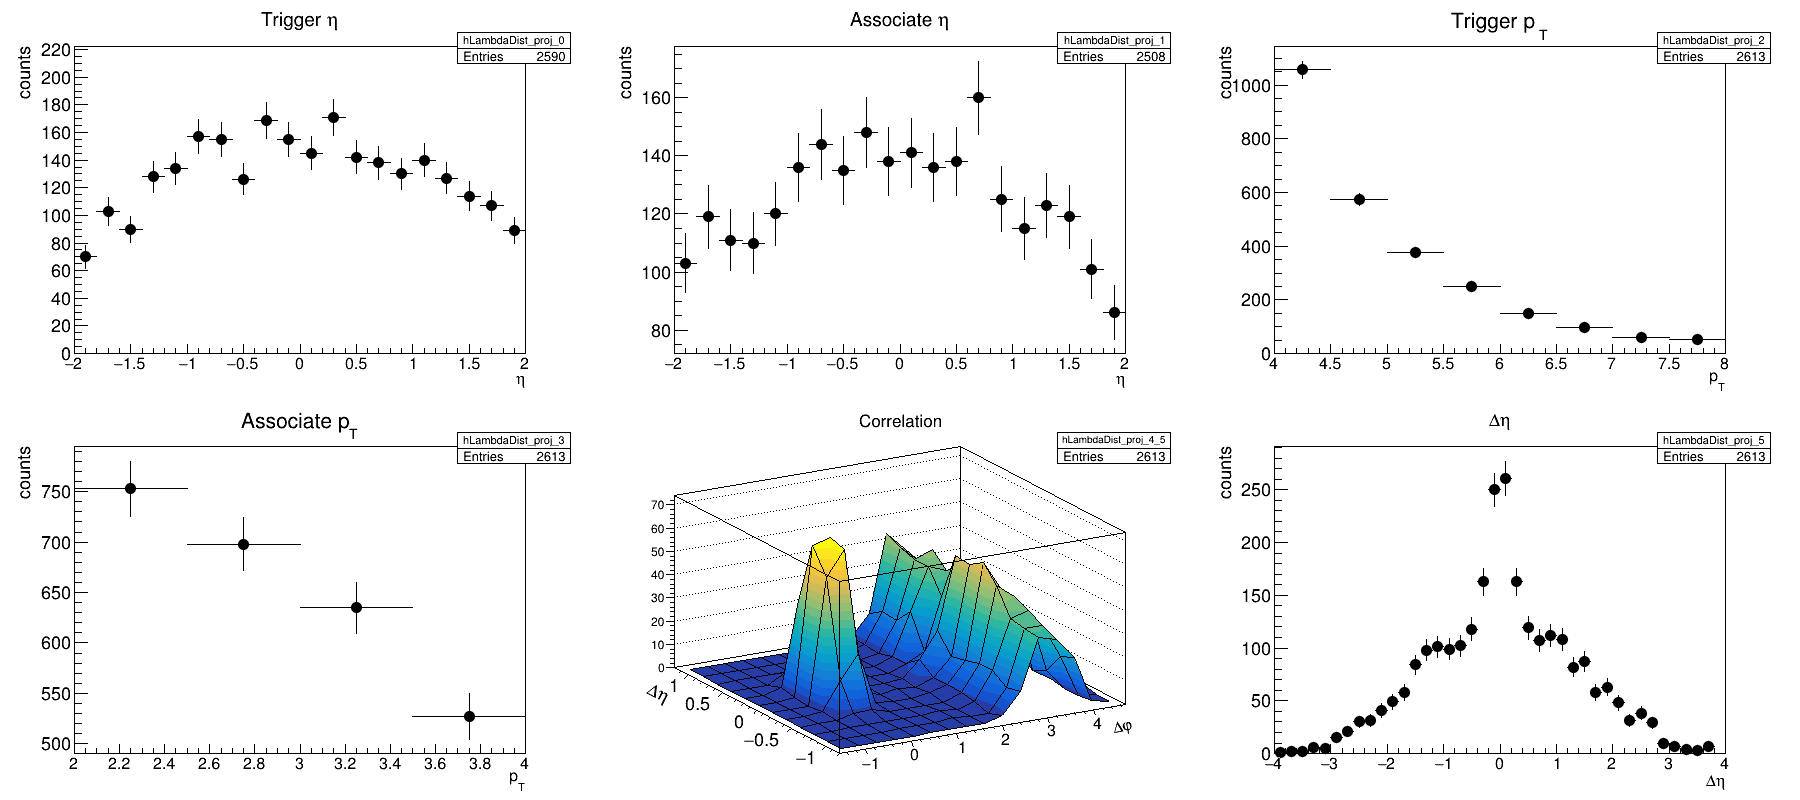

In [ ]:
c2 = make_projection_plots(hlDist, ptTrig, ptAssoc)
c2.Draw()

## Away Side Ratios

In [ ]:
# Skeleton of the following analysis: 
# for both hh and hL
# select pT range for trigger and associate
# for each eta cut
#   plot delta phi delta eta
#   integrate away side peak counts
#   reset eta cut

In [ ]:
def integrate_away_side(correlation):
    '''
    Helper function for get_away_side_ratios(). Calculates the counts in the away side peak of a 2D delta phi delta eta correlation.

    Args
        correlation (TH2):

    Returns
        away_yield (float): 
    '''

    # bounds of integral
    pi = TMath.Pi()
    eps = 0.0001 # in case upper bound lands on right bin edge
    dPhi_lower = pi / 2
    dPhi_upper = 3 * pi / 2 - eps
    dEta_lower = -50
    dEta_upper = 50 - eps

    dPhiLowerBin = correlation.GetXaxis().FindBin(dPhi_lower)
    dPhiUpperBin = correlation.GetXaxis().FindBin(dPhi_upper)

    dEtaLowerBin = correlation.GetYaxis().FindBin(dEta_lower)
    dEtaUpperBin = correlation.GetYaxis().FindBin(dEta_upper)

    away_yield = correlation.Integral(dPhiLowerBin, dPhiUpperBin, dEtaLowerBin, dEtaUpperBin)

    return away_yield

In [ ]:
def get_away_side_ratios(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
    '''
    Given a particular single particle pT and eta cut, 
    returns the ratio of counts in the away side peak for a del phi del eta distribution. 

    Args
        sparse1 (THnSparse): numerator
        sparse2 (THnSparse): denomen
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):

    Returns
        ratios (tuple): h-Lambda / h-h for given single particle and eta cut
    '''

    # apply pT cut
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc
    etaTrigMin, etaTrigMax = etaTrig

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    
    yieldRatios = []
    yieldRatiosUncerts = []
    # iterate over eta cuts
    for etaRange in etaAssoc:
        etaAssocMin, etaAssocMax = etaRange

        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)

        # project into 2D correlations
        dPhiDEta1 = sparse1.Projection(axis['delta eta'], axis['delta phi'])
        dPhiDEta2 = sparse2.Projection(axis['delta eta'], axis['delta phi']) 

        # integrate the counts in the away side peak
        awayCts1 = integrate_away_side(dPhiDEta1)
        awayCts2 = integrate_away_side(dPhiDEta2)

        awayYieldRatio = awayCts1 / awayCts2
        yieldRatios.append(awayYieldRatio)

        # naive calc: standard formula for uncertainty w/ division, assuming we treat the away side as one large bin
        assert awayYieldRatio > 0, 'ratio should be positive'
        sigma = awayYieldRatio * np.sqrt( 1 / awayCts1 + 1 / awayCts2)
        yieldRatiosUncerts.append(sigma)


    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return yieldRatios, yieldRatiosUncerts

In [ ]:
hlOverhh, hlOverhhSigma = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).


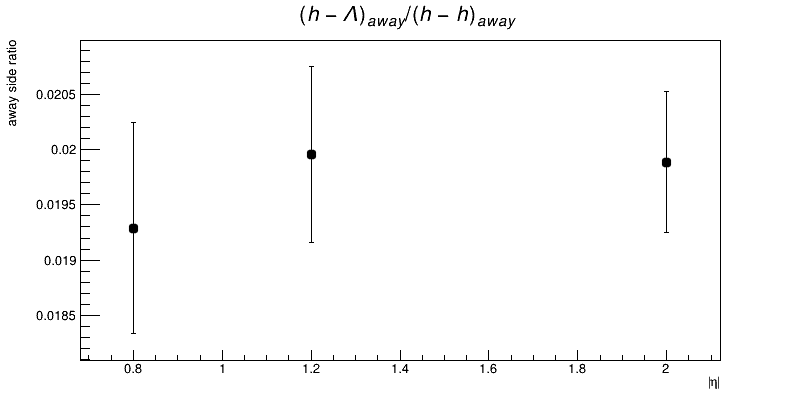

In [ ]:
x = []
for etaRange in eta:
    x.append(np.abs(etaRange[0]))

# flatten data for TGraph
x = np.array(x, dtype='d').ravel()#.flatten('C')
y = np.array(hlOverhh, dtype='d').ravel()#.flatten('C')
sigmax = np.zeros(len(x))
sigmay = np.array(hlOverhhSigma, dtype='d').ravel()

#g = TGraph(len(x), x, y)
assert (len(x) == len(y)) and (len(x) == len(sigmay))
g = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
g.SetMarkerStyle(107)
g.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


gCanvas = TCanvas()
gCanvas.SetCanvasSize(800, 400)
g.Draw("ap") # draw as scatter points and the axis
gCanvas.Draw()

 FCN=0.119585 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=1.07882e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.91052e-02   1.12562e-03   1.43449e-07   6.53022e-09
   2  p1           3.31446e-04   7.28719e-04   1.03428e-07   2.11332e-07


Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existin

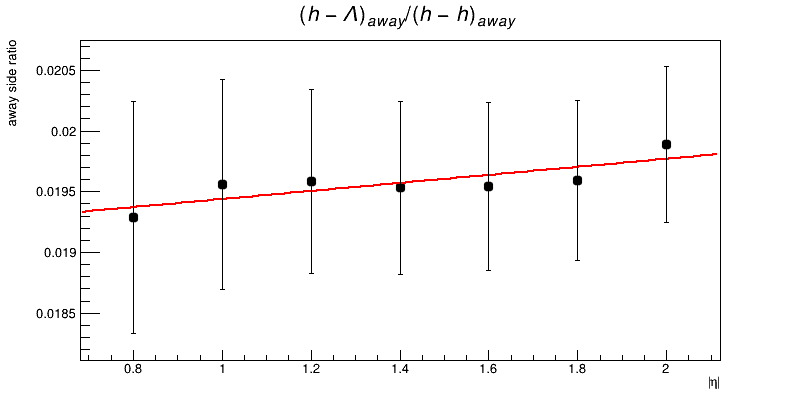

In [ ]:
dense_eta = [[-i*10**-1 , i*10**-1 - eps] for i in range(8, 22, 2)]

x = []
for etaRange in dense_eta:
    x.append(np.abs(etaRange[0]))

y, sigmay = get_away_side_ratios(hlDist, hhDist, ptTrig=[4, 8], ptAssoc=[2, 4], etaTrig=etaTrig, etaAssoc=dense_eta)

x = np.array(x, dtype='d').ravel()
y = np.array(y, dtype='d').ravel()
sigmax = np.zeros(len(x)).ravel()
sigmay = np.array(sigmay, dtype='d')

dg = TGraphErrors(len(x), x, y, ex=sigmax, ey=sigmay)
f = TF1('f', '[0] + [1]*x')
dg.Fit(f)

dg.SetMarkerStyle(107)
dg.SetTitle('#(h - \Lambda)_{away} / (h - h)_{away}; |#eta|; away side ratio')


dgCanvas = TCanvas()
dgCanvas.SetCanvasSize(800, 400)
dg.Draw("ap") # draw as scatter points and the axis
dgCanvas.Draw()

## Plots w/ Cuts

In [ ]:
def gen_plots_w_eta_cuts(sparse, name, ptTrig, ptAssoc, etaTrig, etaAssoc):
    '''
    Args
        sparse (THnSparse):
        ptTrig (array-like):
        ptAssoc (array-like):
        etaRanges (array-like):
    '''

    etaTrigMin, etaTrigMax = etaTrig
    sparse.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    canvases = []
    # iterate over eta cuts
    for i, etaRange in enumerate(etaAssoc):
        etaAssocMin, etaAssocMax = etaRange

        # apply eta cuts
        sparse.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)

        # produce canvas w/ plots
        canvas = make_projection_plots(sparse, ptTrig, ptAssoc)
        canvas.SetName(f'{name}Canvas{np.abs(etaAssocMin)}')
        canvases.append(canvas)    
        
    # reset dist axes
    sparse.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return canvases

In [ ]:
hhCanvas2, hhCanvas12, hhCanvas08 = gen_plots_w_eta_cuts(hhDist, 'hh', ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4_5 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_3 (Potential memory leak).
Warning in <TF

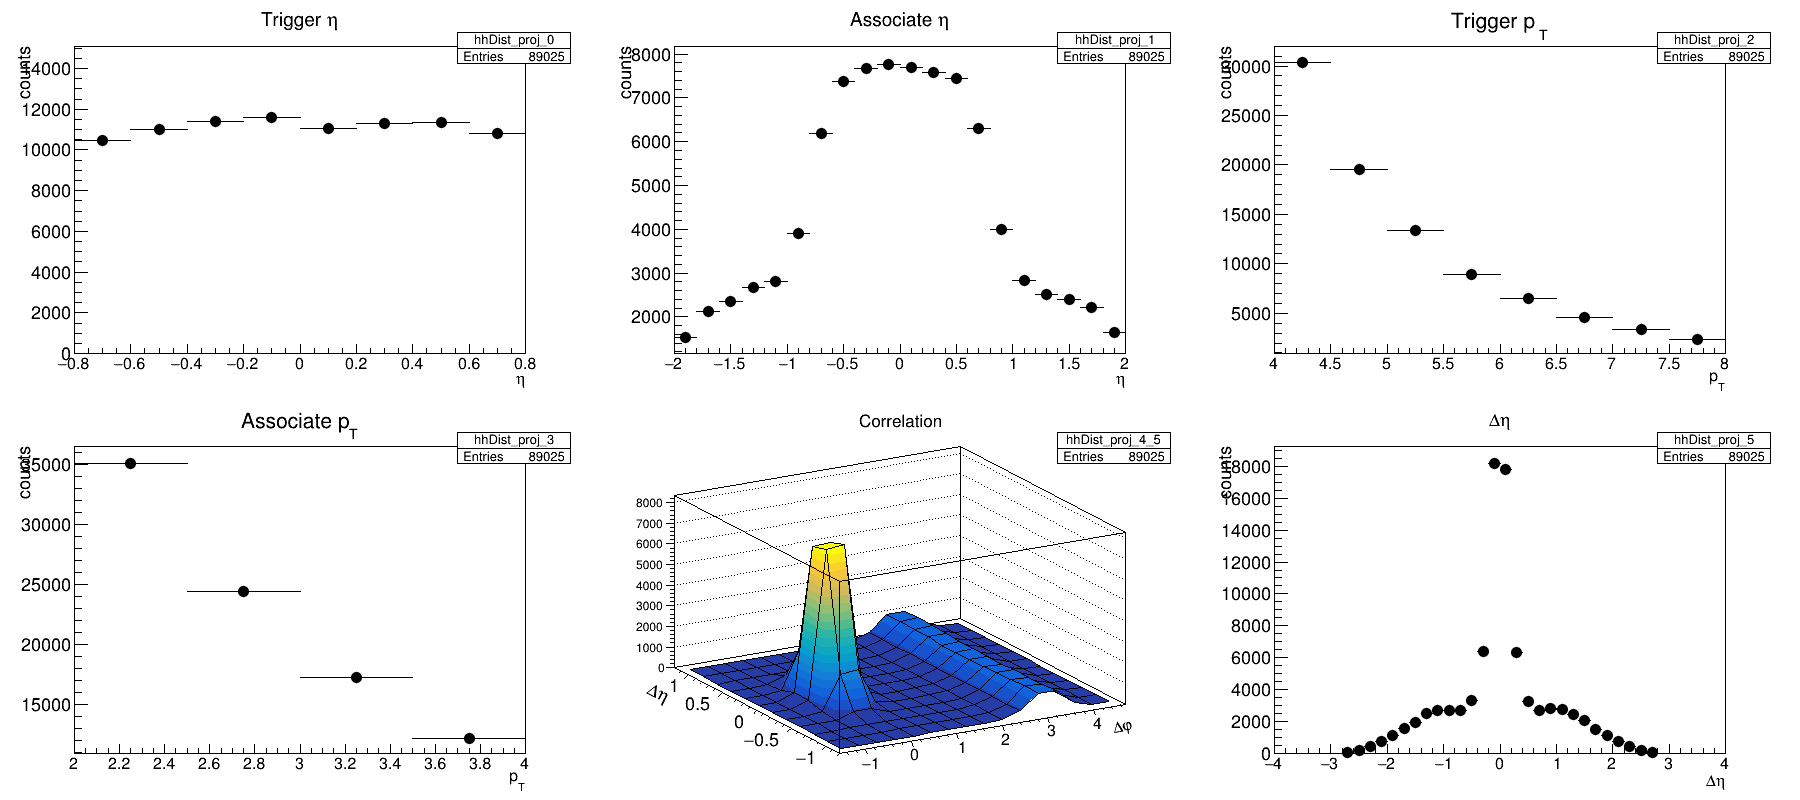

In [ ]:
hhCanvas2.Draw()

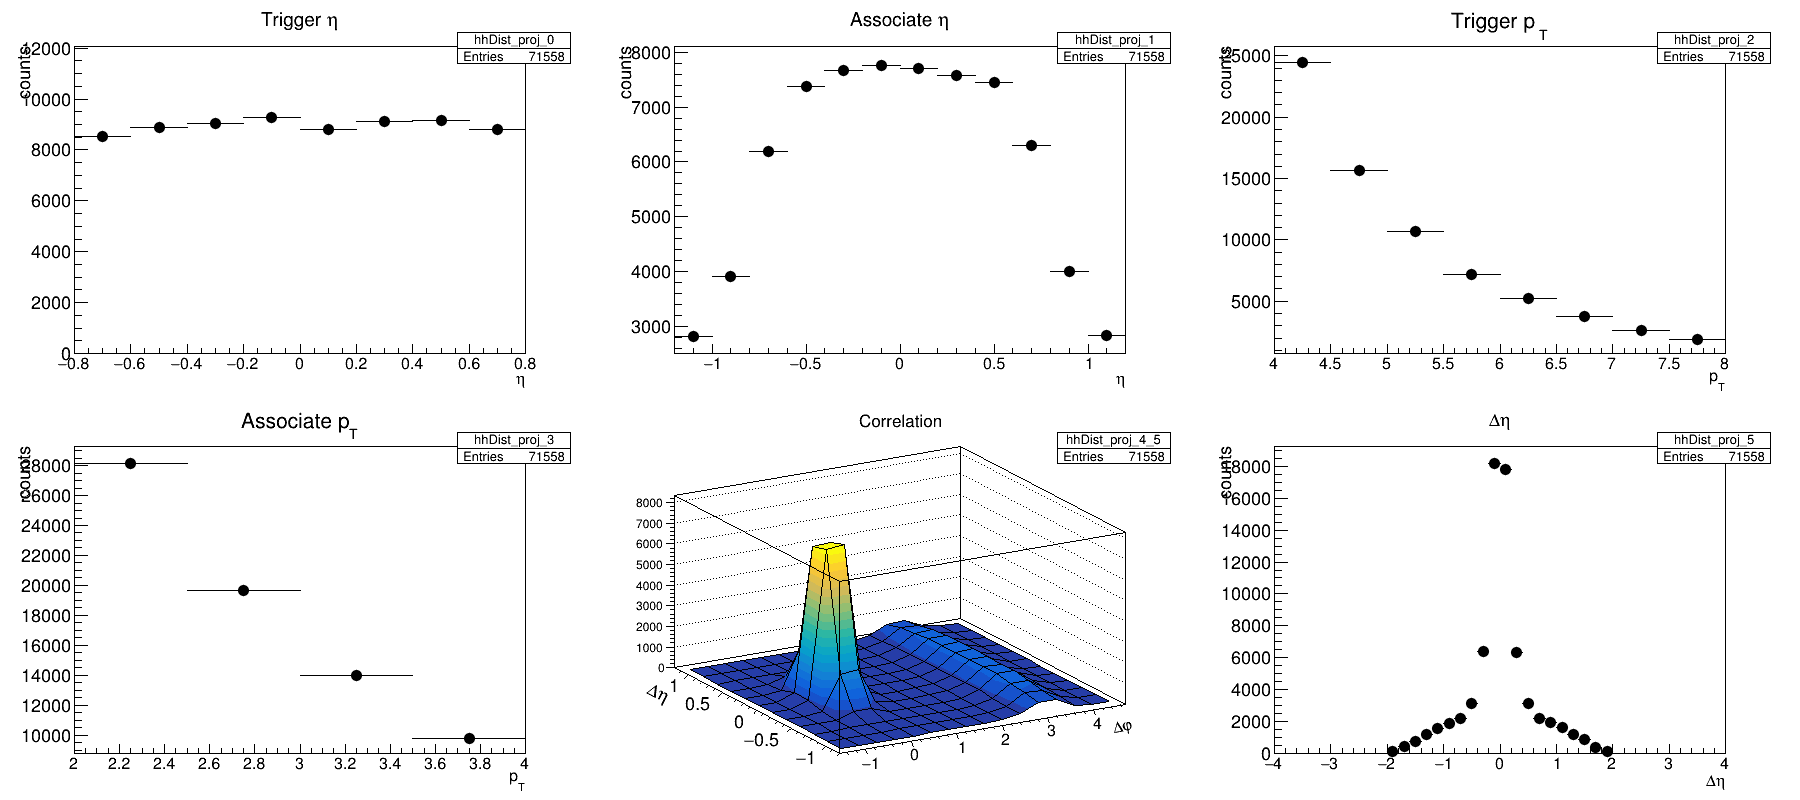

In [ ]:
hhCanvas12.Draw()

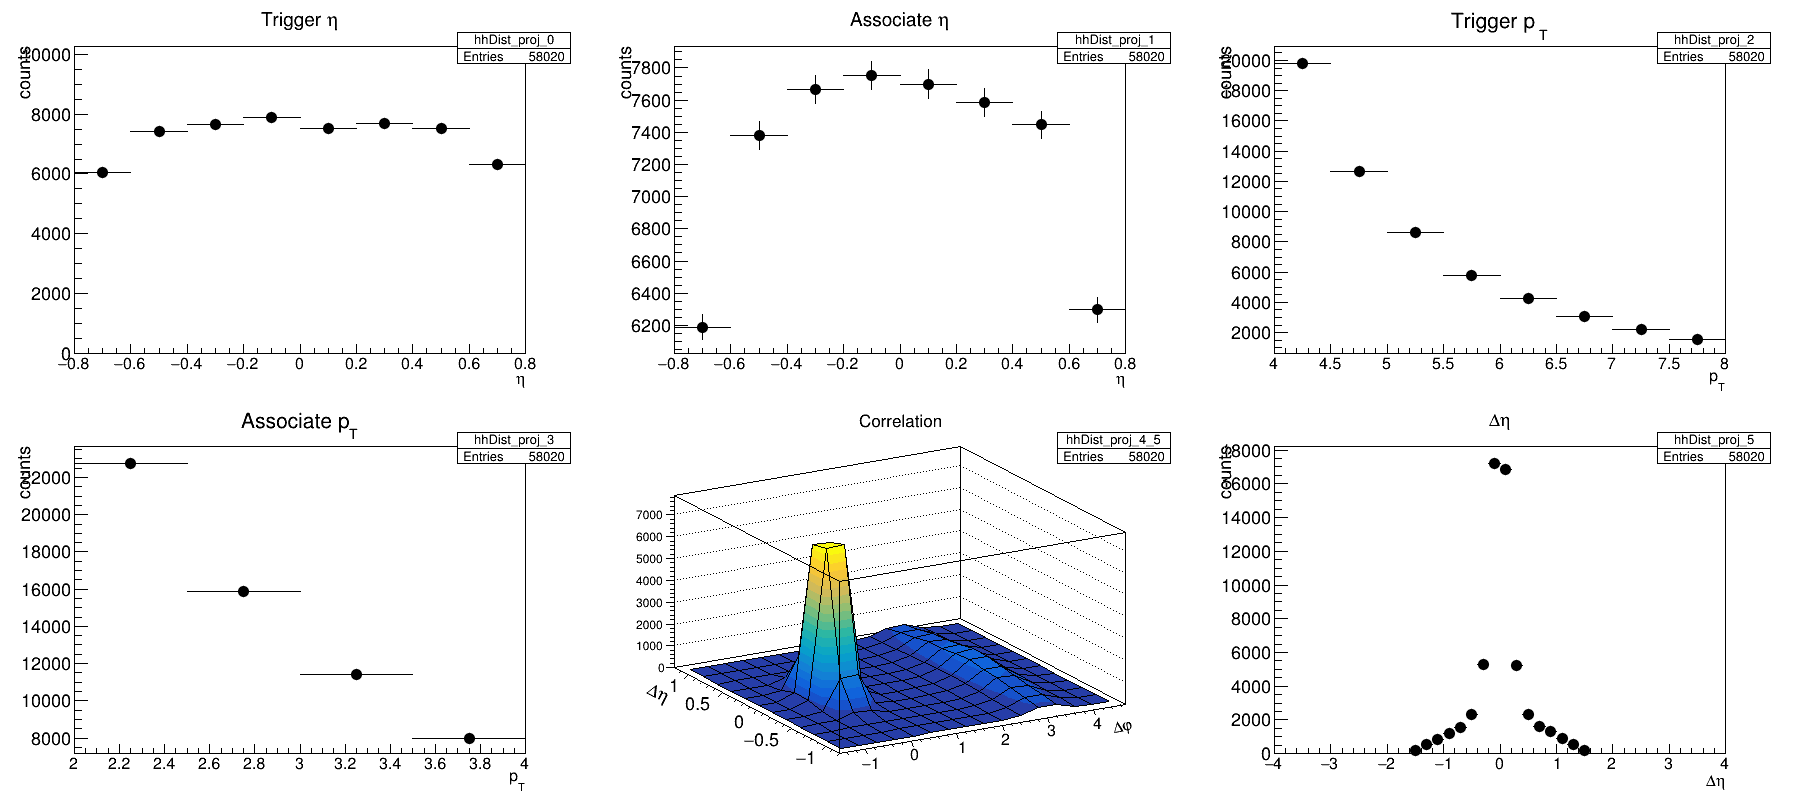

In [ ]:
hhCanvas08.Draw()

In [ ]:
hlCanvas2, hlCanvas12, hlCanvas08 = gen_plots_w_eta_cuts(hlDist, 'hl', ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing 

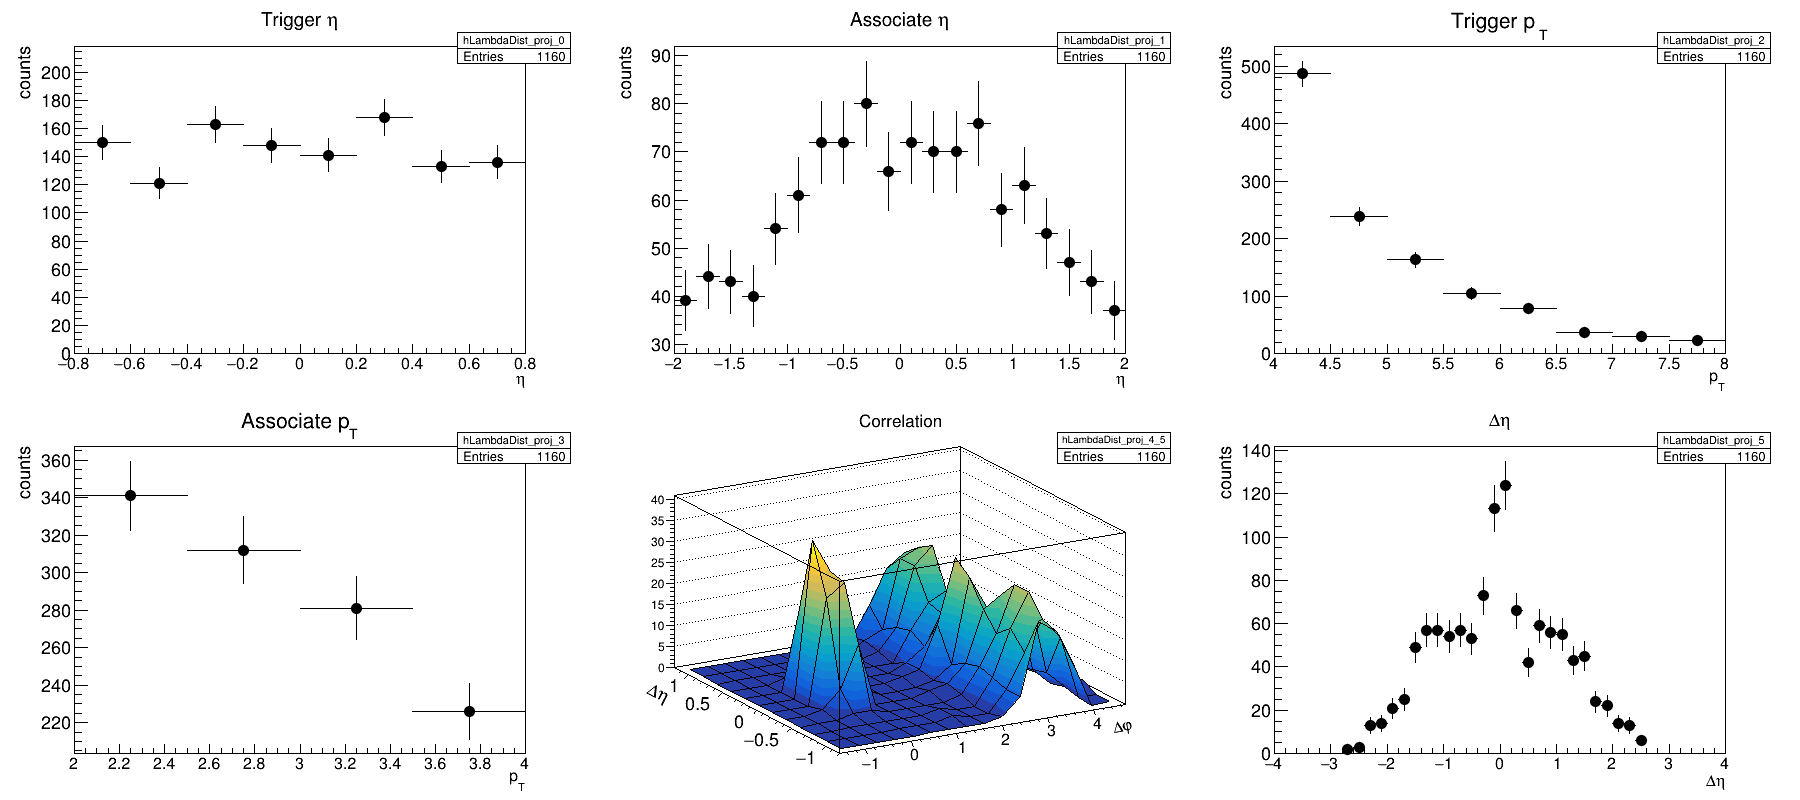

In [ ]:
hlCanvas2.Draw()

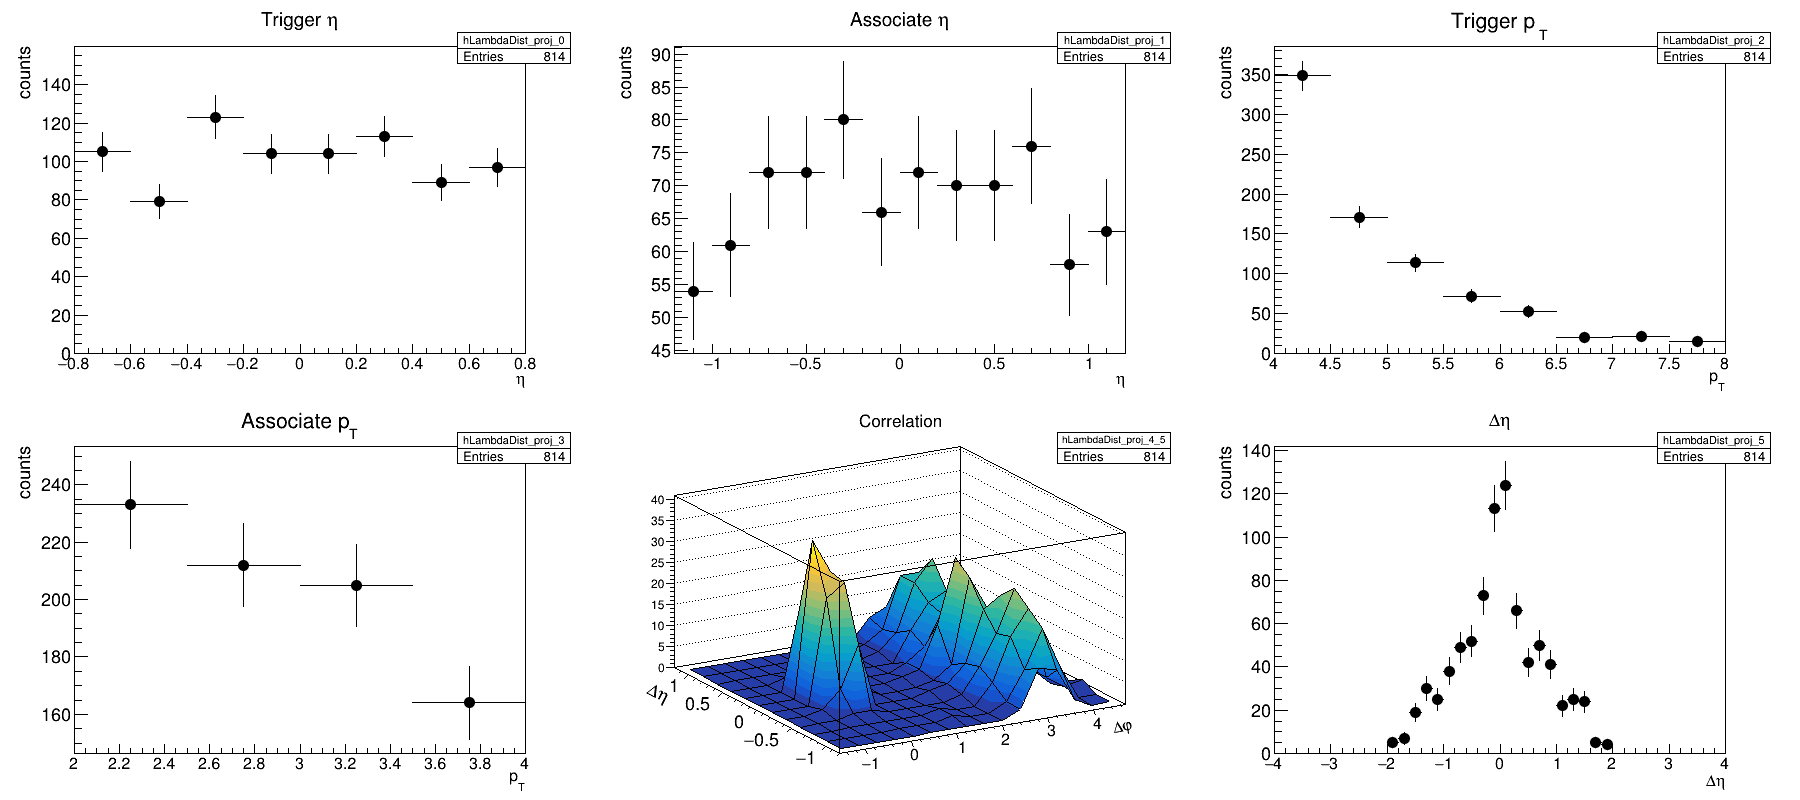

In [ ]:
hlCanvas12.Draw()

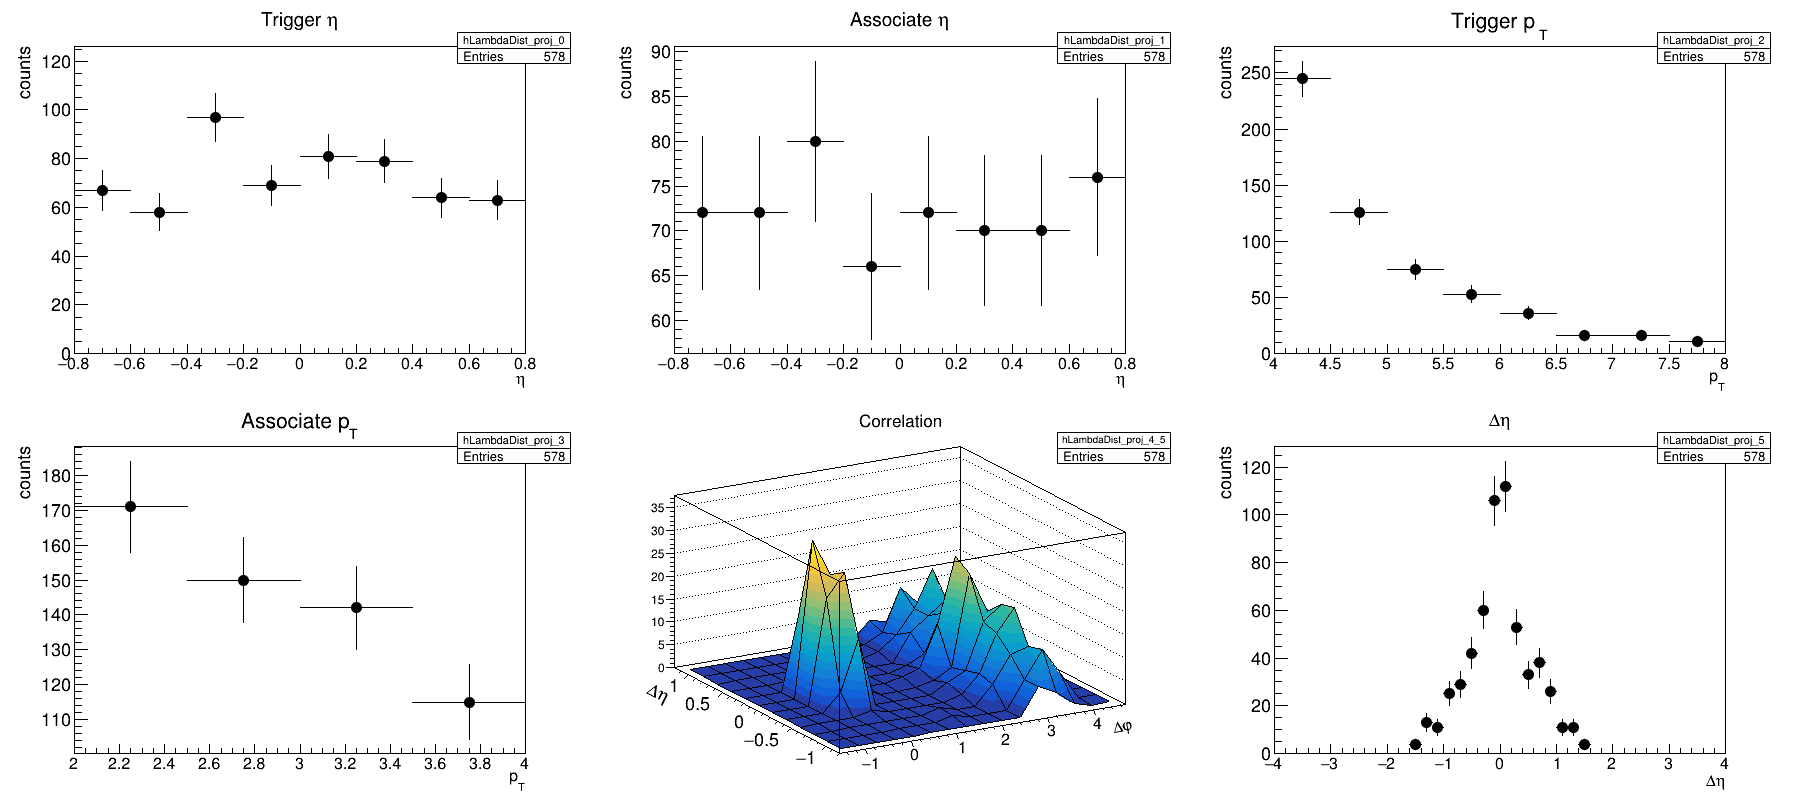

In [ ]:
hlCanvas08.Draw()

## $\Delta \eta$ Distributions for Each Cut

In [ ]:
def make_delta_eta_plots(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
# why no pT cuts??????
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    etaTrigMin, etaTrigMax = etaTrig
    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    canvases = []
    # iterate over eta cuts
    for i, (etaAssocMin, etaAssocMax) in enumerate(etaAssoc):
        canvas = TCanvas()

        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)  

        dEta1 = sparse1.Projection(axis['delta eta'])
        dEta1.Scale(1. / dEta1.Integral())#, "WIDTH")      scale to describe PDF or normalize to a prob distribution 

        dEta2 = sparse2.Projection(axis['delta eta'])
        dEta2.Scale(1. / dEta2.Integral())#, "WIDTH")
        dEta2.SetMarkerColor(2)      

        dEta1.Draw()
        dEta2.Draw('SAME')

        # produce canvas w/ plots
        canvas.SetName(f'delEtaCanvas{np.abs(etaAssocMin)}')
        canvases.append(canvas)

    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return canvases

In [ ]:
dEta2, dEta12, dEta08 = make_delta_eta_plots(hhDist, hlDist, ptTrig, ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_5 (Potential memory leak).


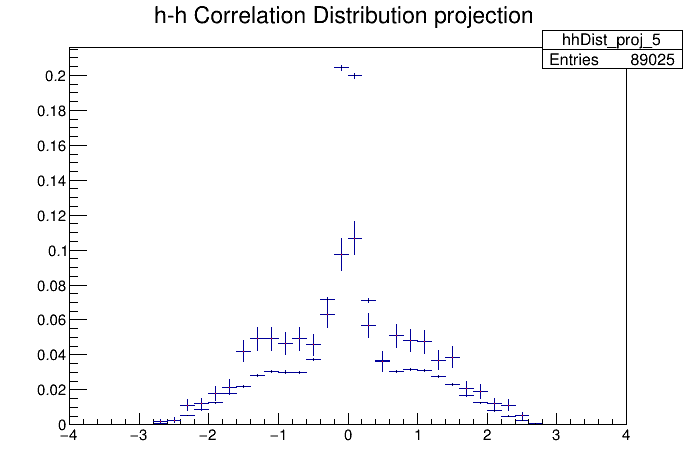

In [ ]:
dEta2.Draw()

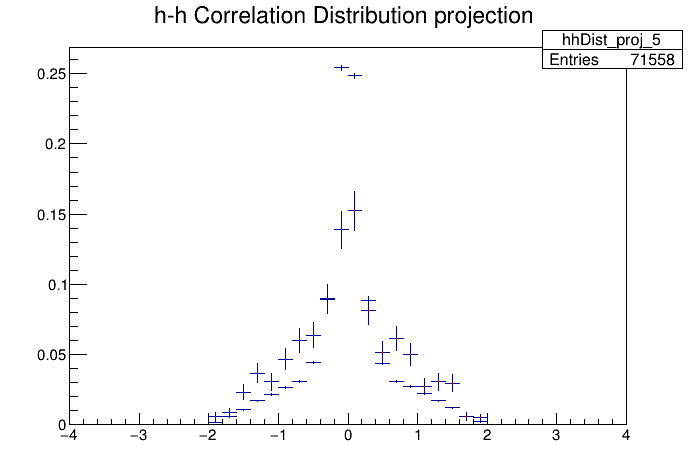

In [ ]:
dEta12.Draw()

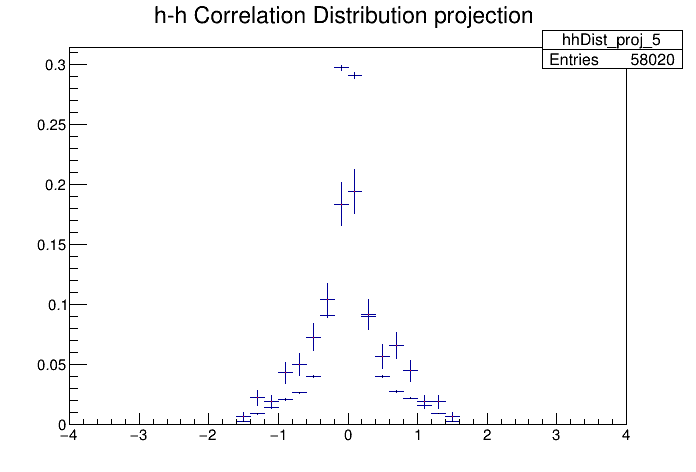

In [ ]:
dEta08.Draw()

## $\Delta \varphi$ Distributions

In [ ]:
def make_delta_phi_plots(sparse1, sparse2, ptTrig, ptAssoc, etaTrig, etaAssoc):
# why no pT cuts??????
    ptTrigMin, ptTrigMax = ptTrig
    ptAssocMin, ptAssocMax = ptAssoc
    etaTrigMin, etaTrigMax = etaTrig

    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(ptTrigMin, ptTrigMax)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(ptAssocMin, ptAssocMax)
    
    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)
    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(etaTrigMin, etaTrigMax)

    # iterate over eta cuts
    sparse1DPhiDists = []
    sparse2DPhiDists = []
    for etaAssocMin, etaAssocMax in etaAssoc:
        # apply eta cuts
        sparse1.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)
        sparse2.GetAxis(axis['associate eta']).SetRangeUser(etaAssocMin, etaAssocMax)  

        dPhi1 = sparse1.Projection(axis['delta phi'])
        dPhi2 = sparse2.Projection(axis['delta phi'])
        
        sparse1DPhiDists.append(dPhi1)
        sparse2DPhiDists.append(dPhi2)

    # reset dist axes
    sparse1.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse2.GetAxis(axis['trigger pT']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate pT']).SetRangeUser(0, 0)

    sparse1.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse1.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    sparse2.GetAxis(axis['trigger eta']).SetRangeUser(0, 0)
    sparse2.GetAxis(axis['associate eta']).SetRangeUser(0, 0)

    return sparse1DPhiDists, sparse2DPhiDists

In [ ]:
hhDPhiDists, hlDPhiDists = make_delta_phi_plots(hhDist, hlDist, ptTrig=ptTrig, ptAssoc=ptAssoc, etaTrig=etaTrig, etaAssoc=eta)

Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hhDist_proj_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hLambdaDist_proj_4 (Potential memory leak).


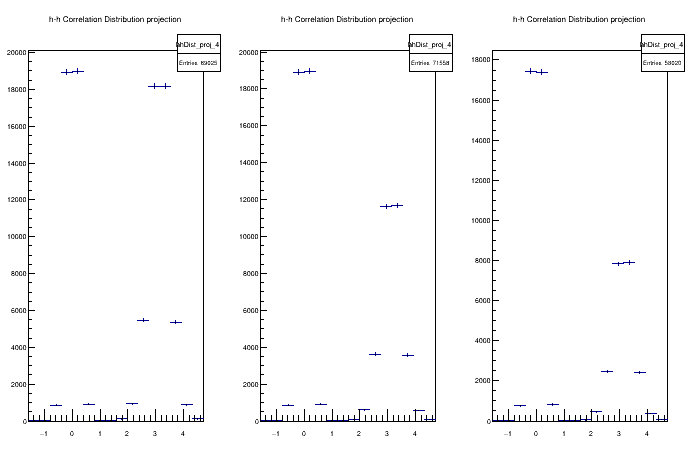

In [ ]:
hhDPhiCanvas = TCanvas()
hhDPhiCanvas.Divide(3, 1)
for i in range(1, 4):
    dist = hhDPhiDists[i-1]
    hhDPhiCanvas.cd(i)
    dist.Draw()

hhDPhiCanvas.Draw()

# Single Particle Distributions

# Code Snippets

In [ ]:
""" 
# get projections
# write projections
# close written file
# reaccess 

def sparse_to_temp_file(sparse):
    '''
    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.

    Args:
        sparse: THnSparse object
    '''
    dPhiDEta = sparse.Projection(5, 4)
    dPhi = sparse.Projection(5)
    dEta = sparse.Projection(4)

    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')
    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')
    tempFile.WriteObject(dPhi, 'dPhi')
    tempFile.WriteObject(dEta, 'dEta') """

" \n# get projections\n# write projections\n# close written file\n# reaccess \n\ndef sparse_to_temp_file(sparse):\n    '''\n    Writes 2D correlations and 1D correlations to a temp file. Keeps the file w/in local scope, so we can safely open it later.\n\n    Args:\n        sparse: THnSparse object\n    '''\n    dPhiDEta = sparse.Projection(5, 4)\n    dPhi = sparse.Projection(5)\n    dEta = sparse.Projection(4)\n\n    tempFile = rt.TFile.Open('tempFile.root', 'RECREATE')\n    tempFile.WriteObject(dPhiDEta, 'dPhiDEta')\n    tempFile.WriteObject(dPhi, 'dPhi')\n    tempFile.WriteObject(dEta, 'dEta') "

In [ ]:
""" sparse_to_temp_file(hhDist)

file = uproot.open('tempFile.root')

dPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()
dPhi, dPhi_edges = file['dPhi'].to_numpy()
dEta, dEta_edges = file['dEta'].to_numpy() """

" sparse_to_temp_file(hhDist)\n\nfile = uproot.open('tempFile.root')\n\ndPhiDEta, x_edges, y_edges = file['dPhiDEta'].to_numpy()\ndPhi, dPhi_edges = file['dPhi'].to_numpy()\ndEta, dEta_edges = file['dEta'].to_numpy() "

In [ ]:
""" # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function
testPhi = np.sum(dPhiDEta, axis=0)
testEta = np.sum(dPhiDEta, axis=1) """

' # https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function\ntestPhi = np.sum(dPhiDEta, axis=0)\ntestEta = np.sum(dPhiDEta, axis=1) '

In [ ]:
""" fig, axs = plt.subplots(1, 3)

axs[0].stairs(testPhi, y_edges)
axs[1].stairs(testEta, x_edges)
axs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) """

" fig, axs = plt.subplots(1, 3)\n\naxs[0].stairs(testPhi, y_edges)\naxs[1].stairs(testEta, x_edges)\naxs[2].imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]) "

In [ ]:
""" # Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax_histx.hist(testPhi, bins=y_edges)
ax_histy.hist(testEta, bins=x_edges, orientation='horizontal') """

" # Start with a square Figure.\nfig = plt.figure(figsize=(6, 6))\n# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between\n# the size of the marginal axes and the main axes in both directions.\n# Also adjust the subplot parameters for a square plot.\ngs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),\n                      left=0.1, right=0.9, bottom=0.1, top=0.9,\n                      wspace=0.05, hspace=0.05)\n# Create the Axes.\nax = fig.add_subplot(gs[1, 0])\nax_histx = fig.add_subplot(gs[0, 0], sharex=ax)\nax_histy = fig.add_subplot(gs[1, 1], sharey=ax)\n\nax.imshow(dPhiDEta.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])\nax_histx.hist(testPhi, bins=y_edges)\nax_histy.hist(testEta, bins=x_edges, orientation='horizontal') "

In [ ]:
""" def sparse_to_uproot(sparse):
    '''
    Takes THnSparse and returns a 2D correlation with projections into eta and phi.
    '''




    
     

 """

" def sparse_to_uproot(sparse):\n    '''\n    Takes THnSparse and returns a 2D correlation with projections into eta and phi.\n    '''\n\n\n\n\n    \n     \n\n "

In [ ]:
""" file = uproot.open('testFile.root') """

" file = uproot.open('testFile.root') "

In [ ]:
""" file.keys() """

' file.keys() '

In [ ]:
""" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
myhist, xedges, yedges= file['myhist'].to_numpy()

fig, ax = plt.subplots()
plt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) """

" # https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html\nmyhist, xedges, yedges= file['myhist'].to_numpy()\n\nfig, ax = plt.subplots()\nplt.imshow(myhist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]) "

In [ ]:
""" # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html



fig = plt.figure()
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)


 """

' # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html\n\n\n\nfig = plt.figure()\nax = fig.add_gridspec(top=0.75, right=0.75).subplots()\nax.set(aspect=1)\n\nax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)\nax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)\n\n\n '